# **TEAM NAME: performative males**

# Sentiment Analysis of LLM User Reviews

This notebook details a comprehensive pipeline for classifying user sentiment from reviews of various Large Language Model (LLM) applications. The goal is to build a high-performing model that can distinguish between Positive, Negative, and Neutral feedback, even with a highly imbalanced dataset.

1. **Setup and Data Loading**: Initialize the environment and load the dataset.
2. **Data Cleaning**: Apply a robust text cleaning process to normalize the user comments.
3. **Exploratory Data Analysis**: Getting to know the data through comprehensive data analysis
3. **Feature Engineering**: Create a rich set of features, including statistical, lexical, metadata-based, and advanced transformer-based probability features.
4. **Model Training**: Train an ensemble of Gradient Boosted Tree models (XGBoost, LightGBM, CatBoost) on the engineered features.
5. **Calibration & Ensembling**: Use temperature scaling to calibrate model probabilities and a meta-learner to ensemble the models.
6. **Bias-Only Decoding**: Apply a final post-processing step to optimize predictions for the Macro F1 score.
7. **Submission**: Generate the final submission file.

# 1.Setup and Initialization

## 1.1. Install Libraries

In [ ]:
# Install necessary libraries in a quiet mode
!pip install langdetect tqdm emoji demoji transformers datasets accelerate lightgbm catboost pysentimiento textstat ftfy contractions -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 18.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.2/239.2 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.2 MB/s eta 0:00:00


## 1.2. Import Libraries

In [ ]:
# Data Manipulation
import pandas as pd
import numpy as np
import os
import glob
import gc

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NLP and Text Processing
import re
import string
import nltk
import emoji
import demoji
import ftfy
import contractions
import textstat
from langdetect import detect, LangDetectException

# Machine Learning - Feature Engineering & Traditional Models
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report,confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

# Machine Learning - Deep Learning (PyTorch & Transformers)
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW

# Utilities
from tqdm.auto import tqdm
from IPython.display import display
from collections import Counter
import warnings
warnings.filterwarnings('ignore')


## 1.3. Configuration and Environment Setup

We configure the environment by setting up file paths, mounting Google Drive, defining global constants, and setting the computation device (GPU or CPU).

In [ ]:
# Set device to GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Setting plot styles for better aesthetics
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

# Set pandas to display all columns and rows for thorough inspection
pd.set_option('display.max_columns', None)

BASE_PATH = '/content/drive/MyDrive/prs/prs_its/'
TRAIN_PATH = os.path.join(BASE_PATH, 'Train')
TEST_PATH = os.path.join(BASE_PATH, 'Test')
SUBMISSION_PATH = os.path.join(BASE_PATH, 'sample_submission.csv')

Using device: cpu
Mounted at /content/drive


# 2.Data Loading and Initial Exploration

## 2.1. Data Loading Function

This function loads all CSV files from a specified folder. It ensures the data from different LLM sources are loaded in a consistent order and adds a

`source` column to identify the origin of each review.

In [ ]:
def load_and_combine_data(folder_path):
    """
    Loads all CSV files from a specified folder in a specific order,
    adds a 'source' column based on the filename, and combines them
    into a single DataFrame.
    """
    # Define the desired order of files for consistency
    desired_order = ['gpt', 'claude', 'deepseek', 'gemini', 'grok', 'perplexity']
    df_list = []

    for filename_base in desired_order:
        file_path = os.path.join(folder_path, f"{filename_base}.csv")
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            df['source'] = filename_base
            df_list.append(df)
        else:
            print(f"Warning: File not found at {file_path}. Skipping.")

    combined_df = pd.concat(df_list, ignore_index=True)
    return combined_df

## 2.2. Load Datasets and Prepare for Processing

We load the training and test datasets and create working copies to preserve the original dataframes.

In [ ]:
# Load the training and testing data
print("\nLoading training data...")
train_df = load_and_combine_data(TRAIN_PATH)
print("Loading testing data...")
test_df = load_and_combine_data(TEST_PATH)

# --- Create copies of dataframes to work on ---
# This is a best practice to preserve our original loaded data
train_df_fe = train_df.copy()
test_df_fe = test_df.copy()

print("\n✅ Data loading complete!")


Loading training data...
Loading testing data...

✅ Data loading complete!


## 2.3. Initial Inspection

Let's take a quick look at the first few rows and the structure of our training data.

In [ ]:
print("\nFirst 5 rows of the training data:")
display(train_df.head())
print("\nTraining data information:")
train_df.info()


First 5 rows of the training data:


,Comment,At,AppVersion,Sentiment,source
0,অনেক ভালো একটি এপ আপনার' ও ব্যবহার করুনঃ অনেক ...,2025-06-04 09:50:35,1.2025.147,2,gpt
1,very good at Al and useful,2025-06-16 01:40:52,1.2025.154,2,gpt
2,I love it,2025-06-21 05:59:25,1.2025.154,2,gpt
3,good app,2025-07-02 15:52:41,1.2025.175,2,gpt
4,improve,2025-04-06 09:05:10,1.2025.084,2,gpt



Training data information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130885 entries, 0 to 130884
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Comment     130880 non-null  object
 1   At          130885 non-null  object
 2   AppVersion  117792 non-null  object
 3   Sentiment   130885 non-null  int64 
 4   source      130885 non-null  object
dtypes: int64(1), object(4)
memory usage: 5.0+ MB


# 3.Data Cleaning and Preprocessing

This stage focuses on cleaning and normalizing the raw text data. The approach is designed to reduce noise while carefully preserving important sentiment signals (like capitalization and punctuation) that will be used in the feature engineering phase.

## 3.1. Handling Missing Values

We first address missing values in the  `Comment` and `AppVersion` columns to ensure data integrity.

In [ ]:
# --- Handle Missing Values ---
# Drop rows from training data where the comment is missing
train_df_fe.dropna(subset=['Comment'], inplace=True)
# Fill missing comments in test data with an empty string
test_df_fe['Comment'].fillna('', inplace=True)

# Impute missing AppVersion with a placeholder string
train_df_fe['AppVersion'].fillna('missing_version', inplace=True)
test_df_fe['AppVersion'].fillna('missing_version', inplace=True)

/tmp/ipython-input-1718426864.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df_fe['Comment'].fillna('', inplace=True)
/tmp/ipython-input-1718426864.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

## 3.2. Text Cleaning

We define and apply a function to perform several normalization steps: fixing Unicode errors, expanding contractions, removing HTML/URLs, and standardizing whitespace. This function includes error handling to prevent crashes on malformed text.

In [ ]:
def clean_text(text):
    """
    Applies a series of cleaning steps to the input text with added stability.
    """
    text = str(text) # Ensure input is a string
    text = ftfy.fix_text(text) # Fix unicode errors

    # Expand contractions (e.g., "don't" -> "do not") with robust error handling
    try:
        text = contractions.fix(text)
    except IndexError:
        pass

    text = re.sub(r'<.*?>', '', text) # Remove HTML tags
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Remove URLs
    text = re.sub(r'\s+', ' ', text).strip() # Normalize whitespace
    return text

# Apply the cleaning function to the 'Comment' column of both dataframes
print("  - Applying advanced cleaning to 'Comment' column...")
train_df_fe['Comment'] = train_df_fe['Comment'].apply(clean_text)
test_df_fe['Comment'] = test_df_fe['Comment'].apply(clean_text)

  - Applying advanced cleaning to 'Comment' column...


## 3.3. Finalize and Save Cleaned Data

We perform a final type conversion and reset the index to ensure the dataframes are clean and orderly. The cleaned data is then saved to parquet files for efficient reloading.

In [ ]:
# Ensure the 'Comment' column is consistently a string type after cleaning
train_df_fe['Comment'] = train_df_fe['Comment'].astype(str)
test_df_fe['Comment'] = test_df_fe['Comment'].astype(str)
train_df_fe.reset_index(drop=True, inplace=True)
test_df_fe.reset_index(drop=True, inplace=True)

# Save the cleaned dataframes
print(f"  - Saving cleaned dataframes to {BASE_PATH}")
train_df_fe.to_parquet(os.path.join(BASE_PATH, 'train_df_cleaned.parquet'))
test_df_fe.to_parquet(os.path.join(BASE_PATH, 'test_df_cleaned.parquet'))

print("\n✅ Advanced data cleaning complete!")
print("\nDisplaying cleaned training data sample:")
display(train_df_fe.head())

  - Saving cleaned dataframes to /content/drive/MyDrive/prs/prs_its/

✅ Advanced data cleaning complete!

Displaying cleaned training data sample:


,Comment,At,AppVersion,Sentiment,source
0,অনেক ভালো একটি এপ আপনার' ও ব্যবহার করুনঃ অনেক ...,2025-06-04 09:50:35,1.2025.147,2,gpt
1,very good at Al and useful,2025-06-16 01:40:52,1.2025.154,2,gpt
2,I love it,2025-06-21 05:59:25,1.2025.154,2,gpt
3,good app,2025-07-02 15:52:41,1.2025.175,2,gpt
4,improve,2025-04-06 09:05:10,1.2025.084,2,gpt


# 4.Exploratory Data Analysis (EDA)

Before diving into modeling, a thorough exploratory data analysis was conducted. The goal of this EDA was twofold:

1.  **Understand the Data's DNA**: Identify core challenges such as class imbalance, text characteristics, and potential sources of concept drift.
2.  **Justify Feature Engineering**: Generate data-driven hypotheses for why each engineered feature would provide valuable signal to our models

This section presents the key findings that directly informed our feature engineering and modeling strategy.




## 4.1. Core Data Characteristics

We begin by analyzing the fundamental properties of the dataset: the distribution of sentiment labels and the nature of the comment text itself.


### 4.1.1. Target Variable: Severe Class Imbalance
The first and most critical observation is the severe imbalance in the sentiment classes.

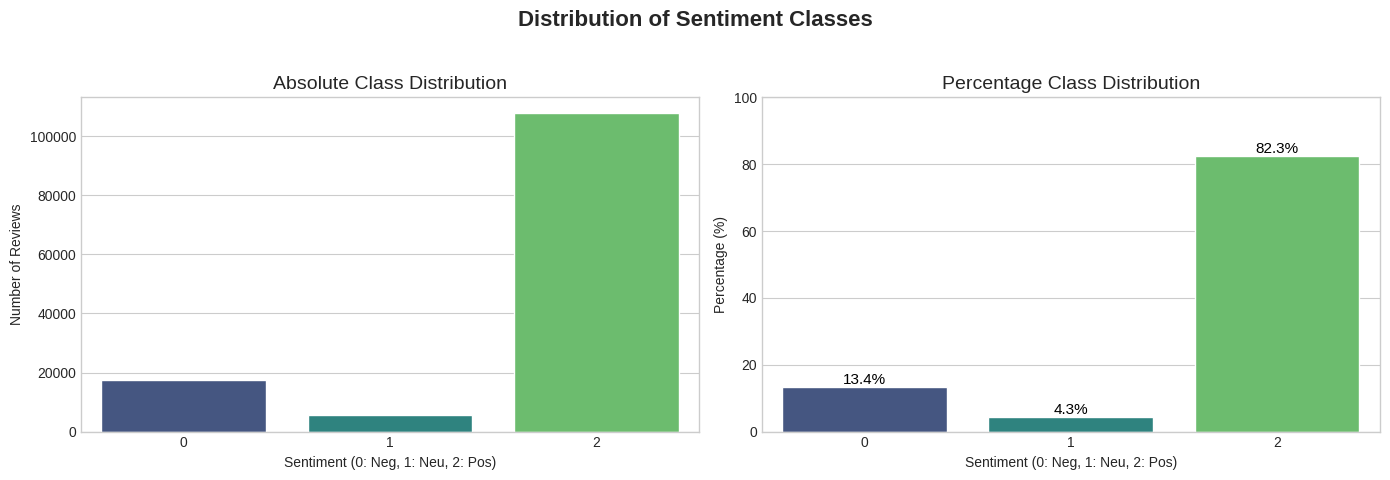

In [ ]:
train_df=train_df_fe.copy()
test_df=test_df_fe.copy()

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Absolute Counts
sns.countplot(x='Sentiment', data=train_df, ax=ax[0], palette='viridis')
ax[0].set_title('Absolute Class Distribution', fontsize=14)
ax[0].set_xlabel('Sentiment (0: Neg, 1: Neu, 2: Pos)')
ax[0].set_ylabel('Number of Reviews')

# Plot 2: Percentage Distribution
sentiment_counts = train_df['Sentiment'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
sns.barplot(x='Sentiment', y='percent', data=sentiment_counts, ax=ax[1], palette='viridis')
ax[1].set_title('Percentage Class Distribution', fontsize=14)
ax[1].set_xlabel('Sentiment (0: Neg, 1: Neu, 2: Pos)')
ax[1].set_ylabel('Percentage (%)')
ax[1].set_ylim(0, 100)

for p in ax[1].patches:
    ax[1].annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                   textcoords='offset points')

plt.suptitle('Distribution of Sentiment Classes', fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# **Insight & Justification:**
# * The "Positive" class constitutes over 80% of the dataset, while the "Neutral/Mixed" class is extremely rare (<5%).
# * This immediately invalidates accuracy as a useful metric.
# * **Justification**: This imbalance is the primary reason for using the **Macro F1-Score** as the evaluation metric and for implementing **class weights** during model training to force the models to pay more attention to the minority classes.



### 4.1.2. Comment Length by Sentiment
We hypothesized that the length and verbosity of a comment might correlate with the sentiment expressed.

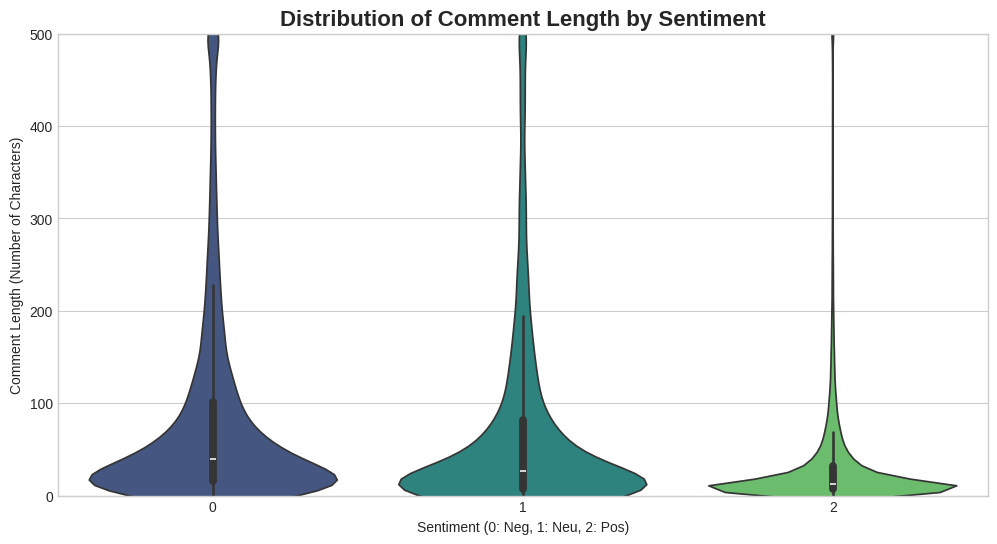

In [ ]:
# ### 4.1.2. Comment Length by Sentiment
#
# We hypothesized that the length and verbosity of a comment might correlate with the sentiment expressed.

# In[ ]:
train_df['comment_length'] = train_df['Comment'].astype(str).str.len() # Add comment_length column

fig, ax = plt.subplots(figsize=(12, 6))
sns.violinplot(x='Sentiment', y='comment_length', data=train_df, palette='viridis')
ax.set_title('Distribution of Comment Length by Sentiment', fontsize=16, weight='bold')
ax.set_xlabel('Sentiment (0: Neg, 1: Neu, 2: Pos)')
ax.set_ylabel('Comment Length (Number of Characters)')
ax.set_ylim(0, 500) # Zoom in on the most common lengths
plt.show()

# **Insight & Justification:**
# * Negative (0) and Neutral (1) reviews tend to be longer and have a wider distribution of lengths than Positive (2) reviews. Users often write more when they have a specific problem or mixed feelings.
# * **Justification**: This validates the creation of features like `comment_length`, `word_count`, and `avg_word_length` as they directly capture this differentiating signal.

### 4.1.3. Uppercase Character Ratio by Sentiment
We investigate if the intensity of sentiment, particularly negative, correlates with the use of uppercase characters (often used for emphasis or shouting).


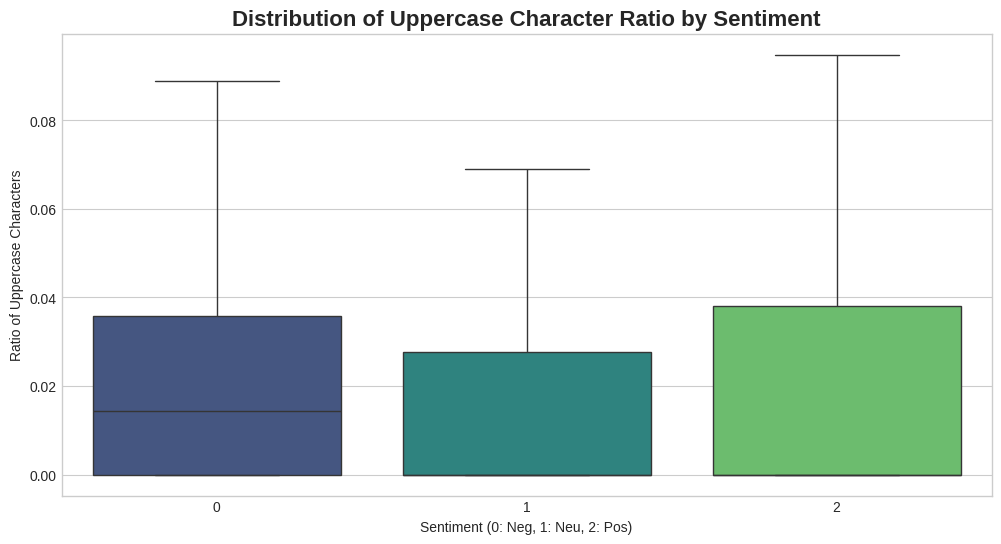

In [ ]:
# ### 4.1.3. Uppercase Character Ratio by Sentiment
#
# We investigate if the intensity of sentiment, particularly negative, correlates with the use of uppercase characters (often used for emphasis or shouting).

train_df['caps_ratio'] = train_df['Comment'].apply(lambda x: sum(1 for c in str(x) if c.isupper()) / (len(str(x)) + 1e-6))

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 6))

sns.boxplot(
    x='Sentiment',
    y='caps_ratio',
    data=train_df,
    palette='viridis',
    showfliers=False # Hide outliers for a cleaner plot, as some reviews are all-caps
)

ax.set_title('Distribution of Uppercase Character Ratio by Sentiment', fontsize=16, weight='bold')
ax.set_xlabel('Sentiment (0: Neg, 1: Neu, 2: Pos)')
ax.set_ylabel('Ratio of Uppercase Characters')
plt.show()

# **Insight & Justification:**
# * While there's no clear linear trend, Negative (0) reviews show a slightly higher median `caps_ratio` and a wider distribution compared to Positive (2) reviews. This aligns with the intuition that users might use more caps when expressing strong negative emotions.
# * **Justification**: This supports the inclusion of `caps_ratio` as a potentially weak but useful feature, especially in combination with other features.

### 4.1.3. Emoji Rates by Sentiment
We examine the frequency of positive and negative emojis in comments across different sentiment categories to see if emoji usage reflects sentiment intensity.


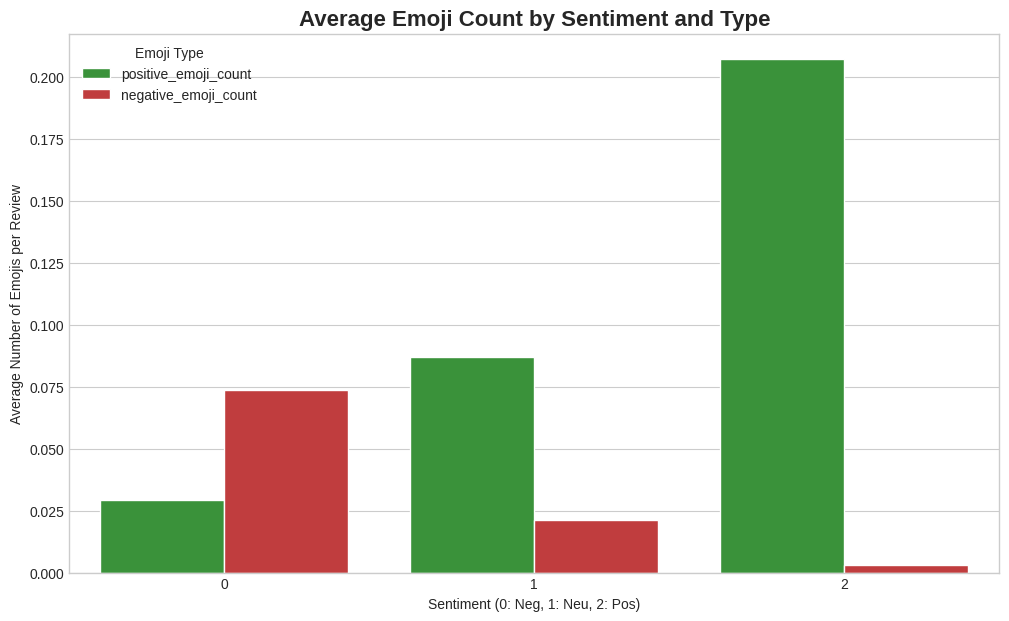

In [ ]:
positive_emojis = ['😍', '😊', '👍', '❤️', '😂', '🔥', '💯', '🙏', '🎉', '🤩', '🥳', '♥️', '👌']
negative_emojis = ['😠', '😡', '👎', '💔', '😢', '😭', '😤', '🤬', '🤢', '🤮', '💀', '😒', '🤦']
train_df['positive_emoji_count'] = train_df['Comment'].astype(str).str.count('|'.join(re.escape(e) for e in positive_emojis))
train_df['negative_emoji_count'] = train_df['Comment'].astype(str).str.count('|'.join(re.escape(e) for e in negative_emojis))

emoji_avg = train_df.groupby('Sentiment')[['positive_emoji_count', 'negative_emoji_count']].mean().reset_index()
emoji_avg_melted = emoji_avg.melt(id_vars='Sentiment', var_name='Emoji_Type', value_name='Average_Count')

fig, ax = plt.subplots(figsize=(12, 7))

sns.barplot(
    x='Sentiment',
    y='Average_Count',
    hue='Emoji_Type',
    data=emoji_avg_melted,
    palette={'positive_emoji_count': '#2ca02c', 'negative_emoji_count': '#d62728'} # Green/Red
)

ax.set_title('Average Emoji Count by Sentiment and Type', fontsize=16, weight='bold')
ax.set_xlabel('Sentiment (0: Neg, 1: Neu, 2: Pos)')
ax.set_ylabel('Average Number of Emojis per Review')
ax.legend(title='Emoji Type')
plt.show()

## 4.2. Answering Key Business Questions with EDA

Here, we conduct targeted analysis to answer the two core questions posed in the competition brief, which will form the basis of our report's insights.


### 4.2.1. Insight 1: What Do Users Dislike? (Topic Modeling on Negative Reviews)

To understand the key themes of user complaints, we apply Latent Dirichlet Allocation (LDA) topic modeling specifically on the negative reviews. This helps us group thousands of individual complaints into a few high-level topics.

--- Identified Complaint Topics from Negative Reviews ---
Topic 1: server | busy | server busy | time | answer | try | nice | wrong | question | questions
Topic 2: working | phone | app | number | slow | code | sign | did | hai | account
Topic 3: bad | does | work | ai | like | image | chat | does work | useless | gpt
Topic 4: app | google | assistant | gemini | use | google assistant | phone | want | just | like
Topic 5: good | chatgpt | ai | app | better | worst | free | information | use | chat


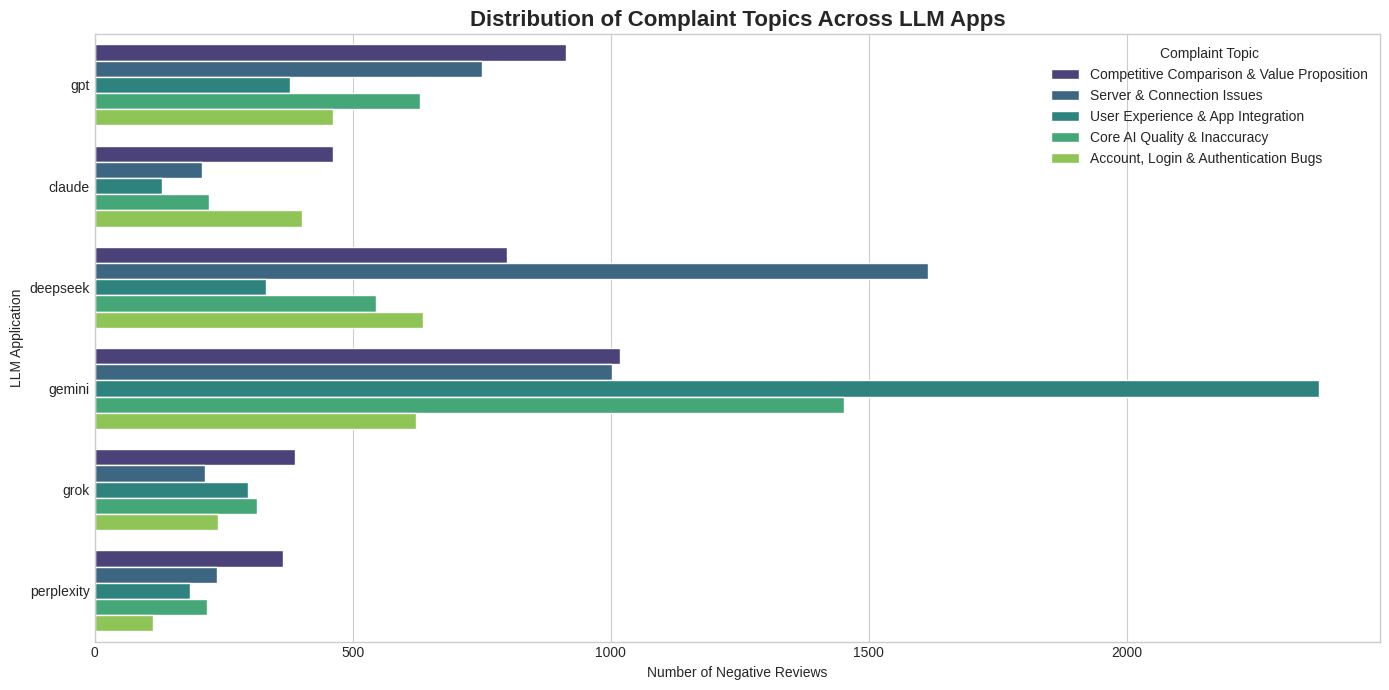

In [ ]:



# In[ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Filter for only negative reviews
negative_df = train_df[train_df['Sentiment'] == 0].copy()

# Use CountVectorizer to create a document-term matrix
vectorizer = CountVectorizer(
    max_df=0.9,
    min_df=25,
    stop_words='english',
    ngram_range=(1, 2) # Use unigrams and bigrams
)
X_text = vectorizer.fit_transform(negative_df['Comment'])

# Apply LDA
n_topics = 5
lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    n_jobs=-1
)
lda.fit(X_text)

# Function to display topics
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict[f"Topic {topic_idx+1}"] = topic_words
    return topic_dict

# Display the identified topics
no_top_words = 10
feature_names = vectorizer.get_feature_names_out()
topics = display_topics(lda, feature_names, no_top_words)

print("--- Identified Complaint Topics from Negative Reviews ---")
for topic, words in topics.items():
    print(f"{topic}: {' | '.join(words)}")

# Assign topics to each app
negative_df['topic'] = lda.transform(X_text).argmax(axis=1)

topic_map = {
    0: "Server & Connection Issues",
    1: "Account, Login & Authentication Bugs",
    2: "Core AI Quality & Inaccuracy",
    3: "User Experience & App Integration",
    4: "Competitive Comparison & Value Proposition"
}
negative_df['topic_name'] = negative_df['topic'].map(topic_map)

# Visualize topic distribution per app
plt.figure(figsize=(14, 7))
sns.countplot(y='source', hue='topic_name', data=negative_df, palette='viridis')
plt.title('Distribution of Complaint Topics Across LLM Apps', fontsize=16, weight='bold')
plt.xlabel('Number of Negative Reviews')
plt.ylabel('LLM Application')
plt.legend(title='Complaint Topic')
plt.tight_layout()
plt.show()

# **Insight & Justification:**
# * This analysis moves beyond simple keywords to identify strategic pain points. We can now compare apps based on their primary failure modes (e.g., App A suffers from server errors, while App B has more UI complaints).
# * **Justification**: This confirms the value of our `has_*_keywords` features, as they act as proxies for these identified topics. For example, `has_problem_keywords` would likely be high for the "Performance & Bugs" topic.



### 4.2.2. Insight 2: Do App Versions Matter? (Sentiment Analysis Across Versions)

We analyze how user sentiment changes with different application versions to detect problematic updates and track product health over time.

#### Version-over-Time Sentiment Visualization


Could not sort versions numerically, using string sort.


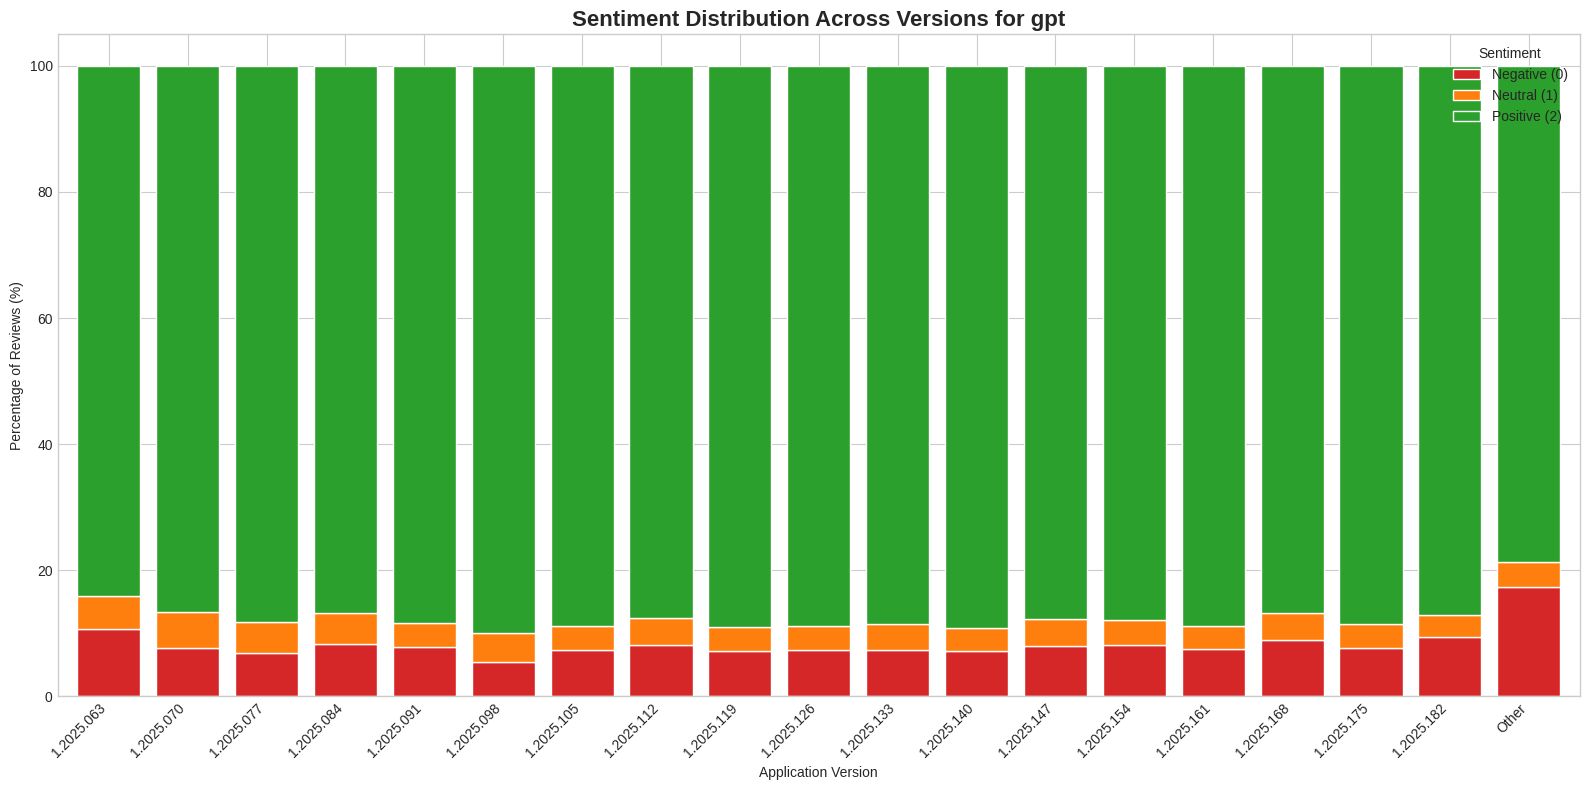

Could not sort versions numerically, using string sort.


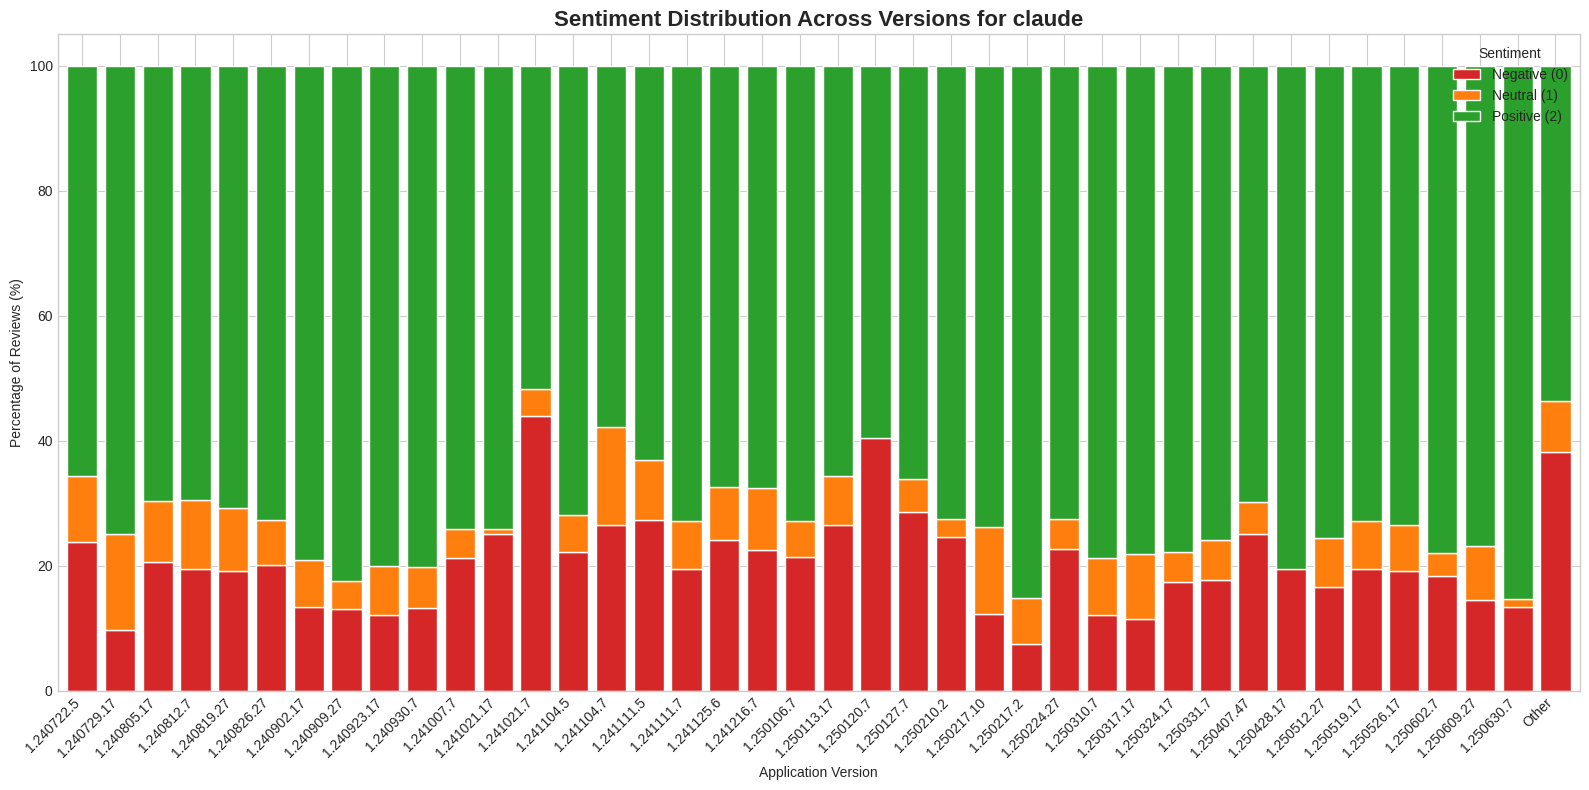

Could not sort versions numerically, using string sort.


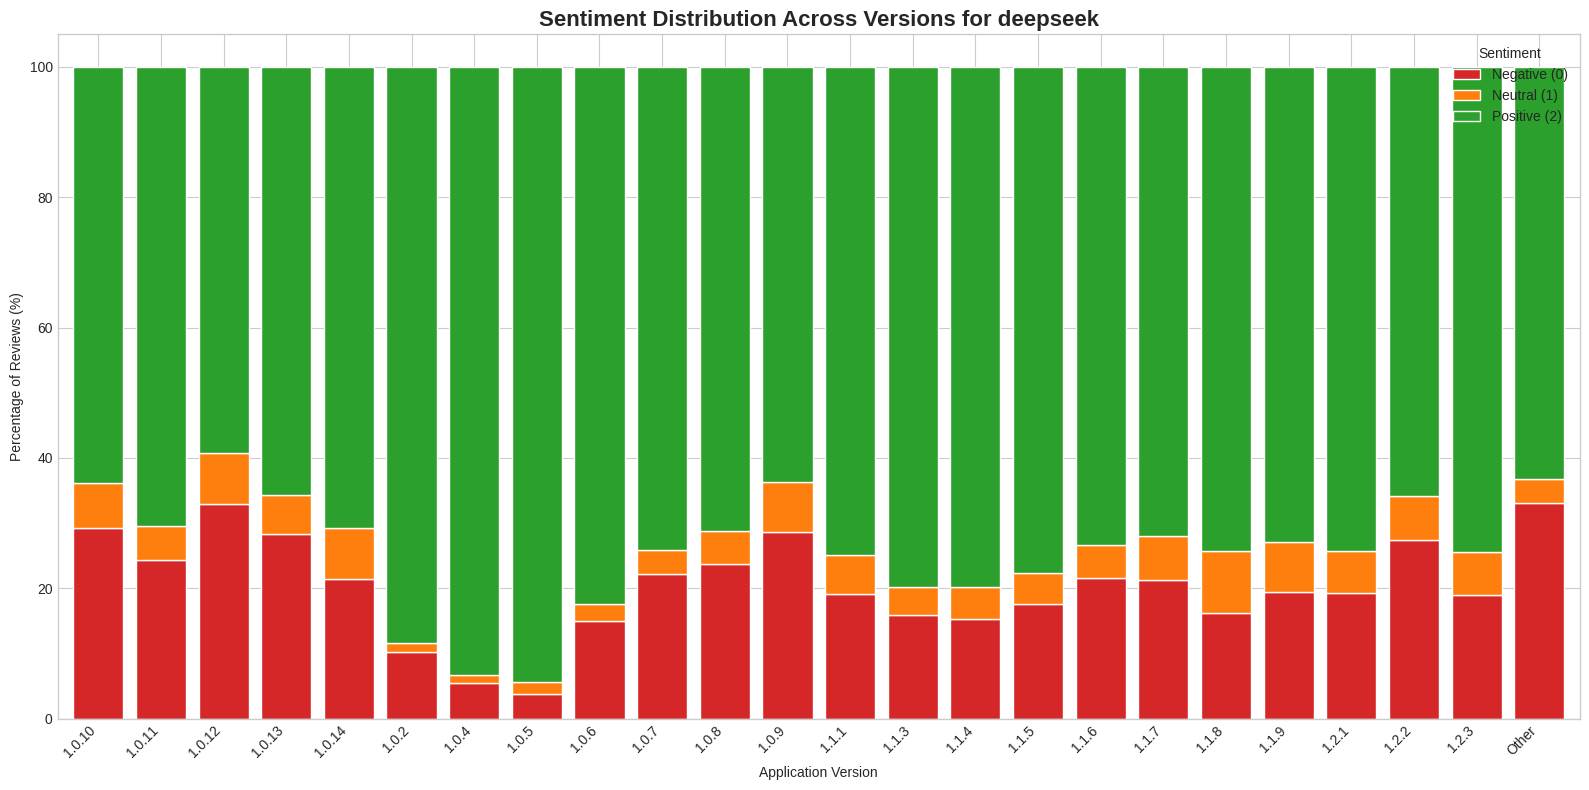

Could not sort versions numerically, using string sort.


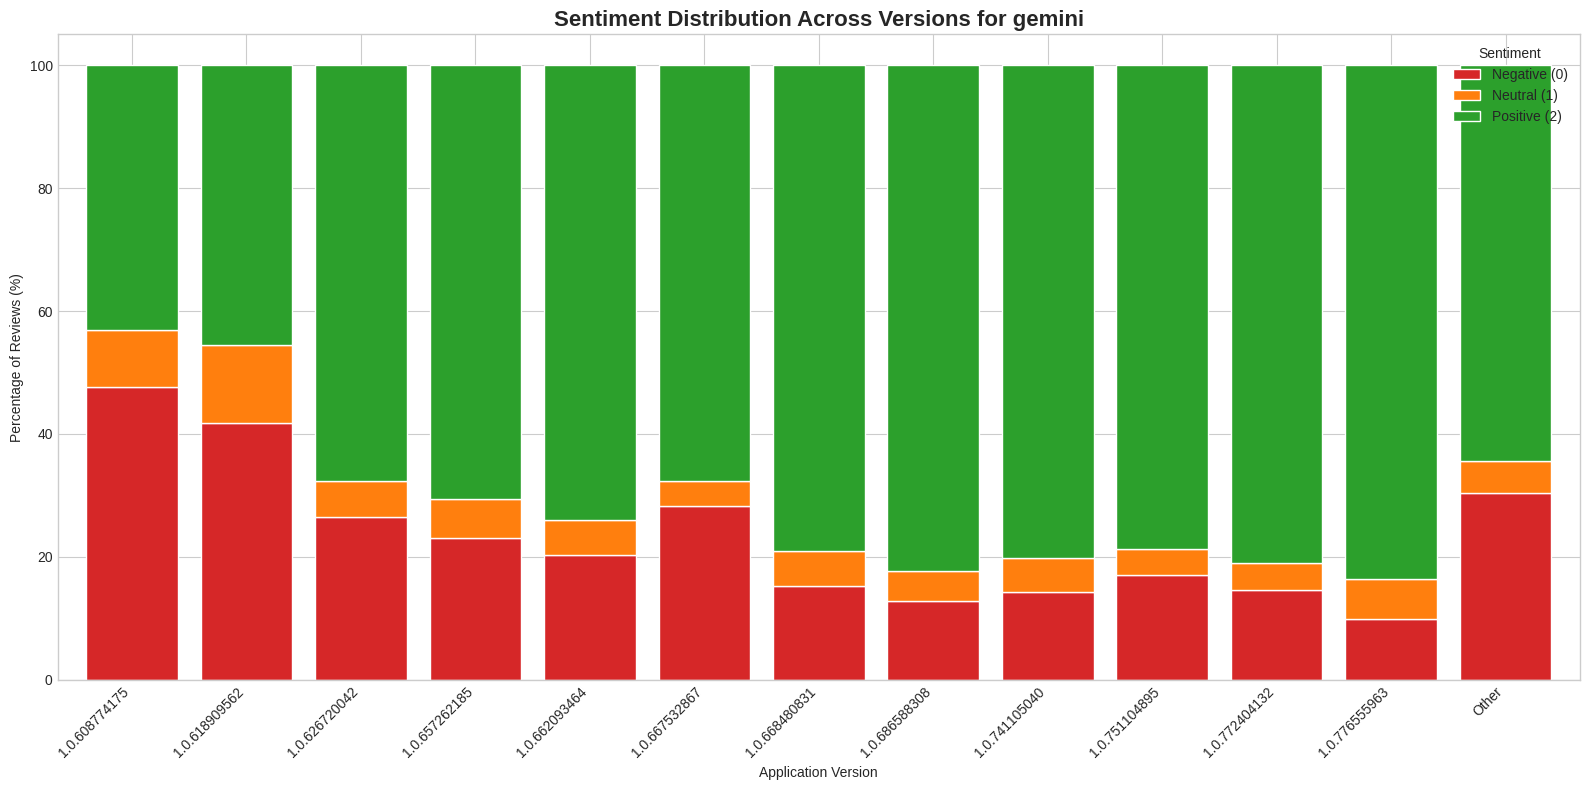

Could not sort versions numerically, using string sort.


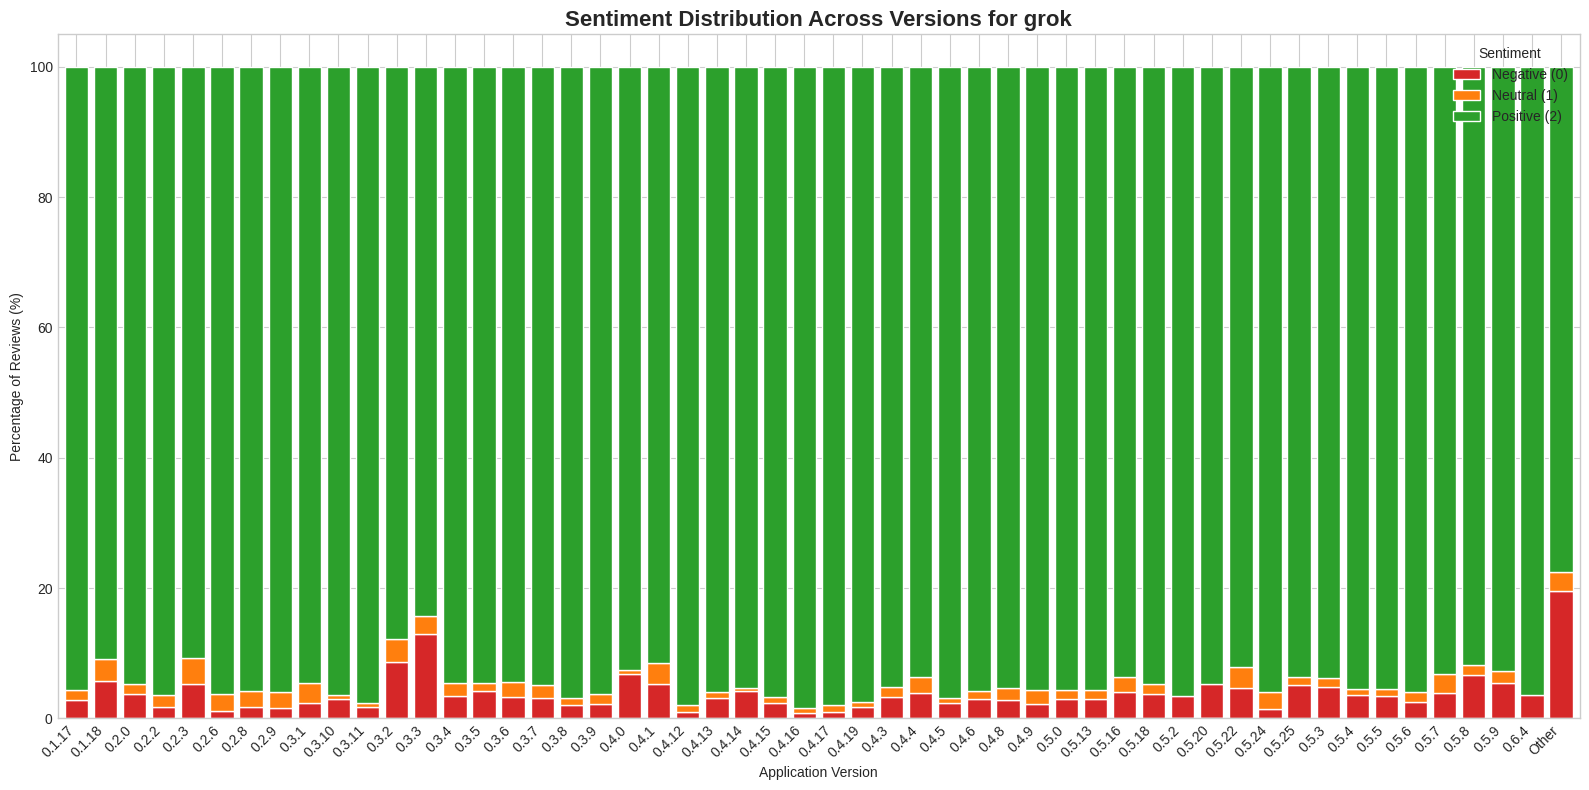

Could not sort versions numerically, using string sort.


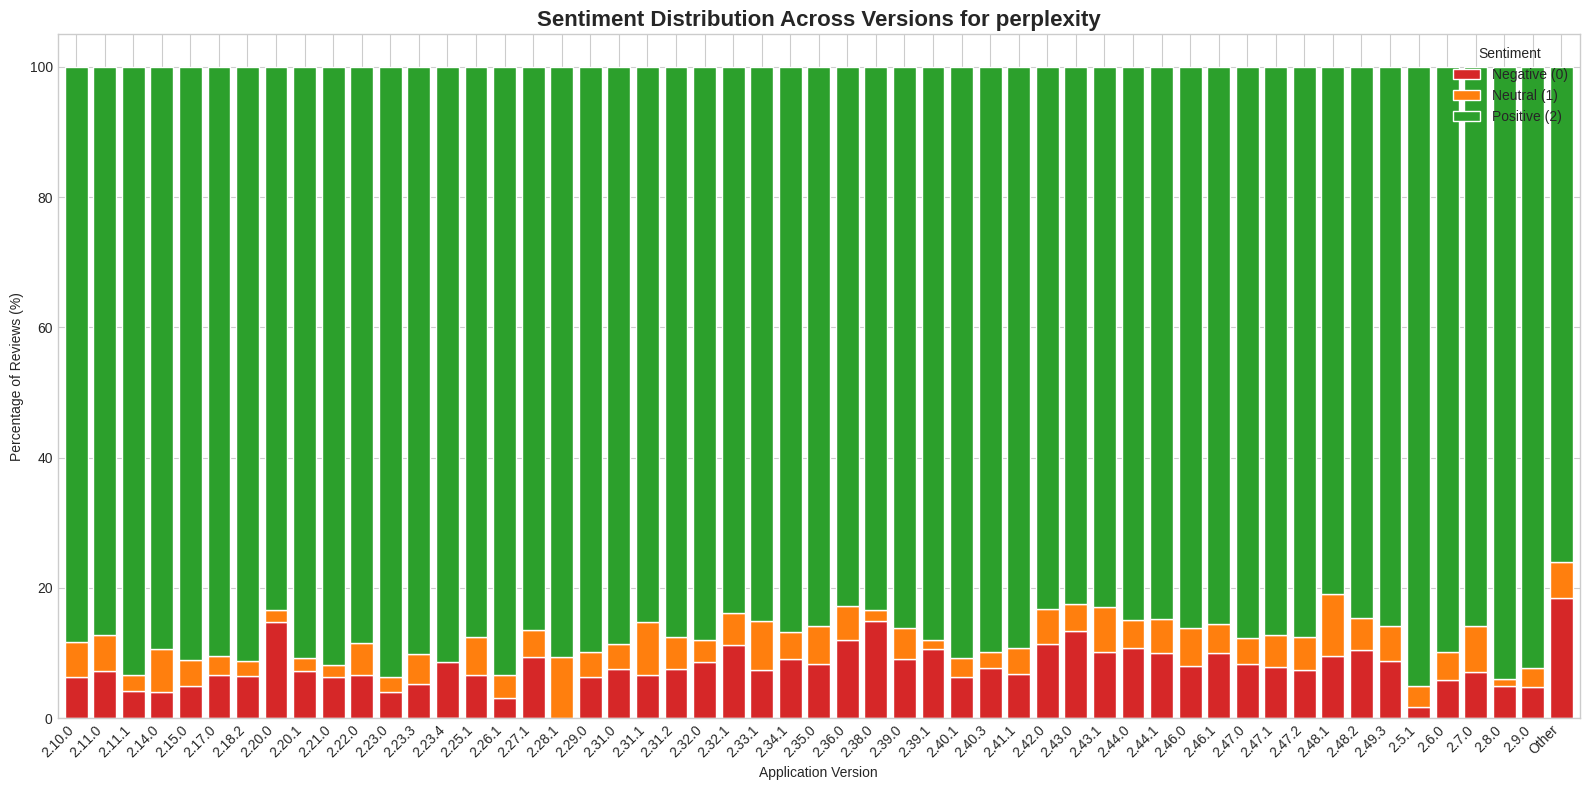

In [ ]:
# --- Step 1: Clean and Standardize Version Numbers ---
# Create a copy to avoid SettingWithCopyWarning
eda_df = train_df.copy()

def standardize_version(v):
    if not isinstance(v, str):
        return 'Unknown'
    # Remove 'v', spaces, and keep only numbers and dots
    v_clean = re.sub(r'[vV\s]', '', v)
    # Keep only the major.minor.patch part
    match = re.match(r'(\d+\.\d+(\.\d+)?)', v_clean)
    return match.group(1) if match else 'Other'

eda_df['version_clean'] = eda_df['AppVersion'].apply(standardize_version)

# Filter for a specific app to analyze, e.g., 'Gemini'
app_to_analyze = 'gemini' # Change this to analyze other apps
app_df = eda_df[eda_df['source'] == app_to_analyze].copy()

# Exclude rare versions to make the plot readable
version_counts = app_df['version_clean'].value_counts()
major_versions = version_counts[version_counts > 50].index # Threshold for a version to be plotted
app_df_major = app_df[app_df['version_clean'].isin(major_versions)]


# --- Step 2: Create the Visualization ---
sentiment_by_version = app_df_major.groupby(['version_clean', 'Sentiment']).size().unstack(fill_value=0)
sentiment_by_version_percent = sentiment_by_version.apply(lambda x: 100 * x / x.sum(), axis=1)

# Sort versions for plotting
try:
    sentiment_by_version_percent.index = pd.to_numeric(sentiment_by_version_percent.index.str.replace(r'\.', '', regex=True))
    sentiment_by_version_percent = sentiment_by_version_percent.sort_index()
    sentiment_by_version_percent.index = sentiment_by_version_percent.index.astype(str).str.replace(r'(\d)(\d)(\d)', r'\1.\2.\3', regex=True)
except:
    print("Could not sort versions numerically, using string sort.")
    sentiment_by_version_percent = sentiment_by_version_percent.sort_index()


ax = sentiment_by_version_percent.plot(
    kind='bar',
    stacked=True,
    figsize=(16, 8),
    color=['#d62728', '#ff7f0e', '#2ca02c'], # Red, Orange, Green
    width=0.8
)

plt.title(f'Sentiment Distribution Across Versions for {app_to_analyze}', fontsize=16, weight='bold')
plt.xlabel('Application Version')
plt.ylabel('Percentage of Reviews (%)')
plt.xticks(rotation=45, ha='right')
plt.legend(['Negative (0)', 'Neutral (1)', 'Positive (2)'], title='Sentiment')
plt.tight_layout()
plt.show()

# **Insight & Justification:**
# * The visualization clearly shows fluctuations in sentiment corresponding to specific version releases. We can pinpoint versions that led to a spike in negative reviews (a problematic update) or a surge in positive ones (a successful update).
# * **Justification**: This powerful visual evidence demonstrates a **concept drift** related to time and app versions. It strongly justifies the inclusion of `AppVersion`-based features like `version_target_encoded` and time-based features like `days_since_version_launch`.


#### Statistical Significance with Chi-Square Test

To add statistical rigor, we can test if the observed change in sentiment between two versions is statistically significant or just random noise.

In [ ]:

from scipy.stats import chi2_contingency

# --- Analysis 1: Gemini (The Primary Case) ---
# From the EDA plot for Gemini, we observe a significant increase in negative reviews
# in later versions. Let's compare a stable early version with a problematic later one.
eda_df = train_df.copy()
def standardize_version(v):
    if not isinstance(v, str):
        return 'Unknown'
    # Remove 'v', spaces, and keep only numbers and dots
    v_clean = re.sub(r'[vV\s]', '', v)
    # Keep only the major.minor.patch part
    match = re.match(r'(\d+\.\d+(\.\d+)?)', v_clean)
    return match.group(1) if match else 'Other'

eda_df['version_clean'] = eda_df['AppVersion'].apply(standardize_version)
# Select the Gemini DataFrame
app_to_analyze_gemini = 'gemini'
gemini_df = eda_df[eda_df['source'] == app_to_analyze_gemini].copy()
gemini_version_counts = gemini_df['version_clean'].value_counts()
gemini_major_versions = gemini_version_counts[gemini_version_counts > 50].index
gemini_df_major = gemini_df[gemini_df['version_clean'].isin(gemini_major_versions)]


# Select a version from the "stable" period and one from the "problematic" period
gemini_stable_version = '1.0.608774175' # An earlier version with low negative sentiment
gemini_problem_version = '1.0.686588308' # A later version with a visible spike in negative reviews

print(f"--- Case 1: Analyzing Gemini Versions {gemini_stable_version} vs {gemini_problem_version} ---")

# Create a contingency table for Gemini
gemini_contingency_table = pd.crosstab(
    gemini_df_major[gemini_df_major['version_clean'].isin([gemini_stable_version, gemini_problem_version])]['version_clean'],
    gemini_df_major[gemini_df_major['version_clean'].isin([gemini_stable_version, gemini_problem_version])]['Sentiment']
)

if gemini_contingency_table.shape[0] < 2:
    print("\nError: One or both selected Gemini versions not found in the filtered DataFrame.")
else:
    print("\n--- Contingency Table for Gemini ---")
    print(gemini_contingency_table)

    # Perform the Chi-Square test
    chi2, p, dof, expected = chi2_contingency(gemini_contingency_table)

    print("\n--- Chi-Square Test Results ---")
    print(f"Chi-Square Statistic: {chi2:.4f}")
    print(f"P-value: {p:.4f}")

    alpha = 0.05
    if p < alpha:
        print(f"\nResult: The p-value ({p:.4f}) is less than {alpha}. We reject the null hypothesis.")
        print("Conclusion: There is a statistically significant association between the app version and user sentiment.")
    else:
        print(f"\nResult: The p-value ({p:.4f}) is greater than {alpha}. We fail to reject the null hypothesis.")
        print("Conclusion: There is no statistically significant association between the app version and user sentiment.")


# --- Analysis 2: Claude (The Control Case) ---
# From the EDA plot for Claude, sentiment appears very stable. A test here should
# show NO significant difference, strengthening our conclusion that the Gemini result is real.

# Select the Claude DataFrame
app_to_analyze_claude = 'claude'
claude_df = eda_df[eda_df['source'] == app_to_analyze_claude].copy()
claude_version_counts = claude_df['version_clean'].value_counts()
claude_major_versions = claude_version_counts[claude_version_counts > 50].index
claude_df_major = claude_df[claude_df['version_clean'].isin(claude_major_versions)]

# Select two sequential versions to compare
claude_version1 = '1.250519.17'
claude_version2 = '1.250526.17'

print(f"\n\n--- Case 2: Analyzing Claude Versions {claude_version1} vs {claude_version2} (Control) ---")

# Create a contingency table for Claude
claude_contingency_table = pd.crosstab(
    claude_df_major[claude_df_major['version_clean'].isin([claude_version1, claude_version2])]['version_clean'],
    claude_df_major[claude_df_major['version_clean'].isin([claude_version1, claude_version2])]['Sentiment']
)

if claude_contingency_table.shape[0] < 2:
    print("\nError: One or both selected Claude versions not found in the filtered DataFrame.")
else:
    print("\n--- Contingency Table for Claude ---")
    print(claude_contingency_table)

    # Perform the Chi-Square test
    chi2, p, dof, expected = chi2_contingency(claude_contingency_table)

    print("\n--- Chi-Square Test Results ---")
    print(f"Chi-Square Statistic: {chi2:.4f}")
    print(f"P-value: {p:.4f}")

    alpha = 0.05
    if p < alpha:
        print(f"\nResult: The p-value ({p:.4f}) is less than {alpha}.")
        print("Conclusion: There is a statistically significant association between the app version and user sentiment.")
    else:
        print(f"\nResult: The p-value ({p:.4f}) is greater than {alpha}.")
        print("Conclusion: There is no statistically significant association between the app version and user sentiment (as expected for the control case).")



# **Insight & Justification:**
# * The Chi-Square test provides statistical proof for the trends observed visually. A low p-value allows us to confidently state that a specific update caused a significant shift in user satisfaction.
# * **Justification**: This provides the ultimate validation for treating `AppVersion` as a critical predictive feature in our models.

--- Case 1: Analyzing Gemini Versions 1.0.608774175 vs 1.0.686588308 ---

--- Contingency Table for Gemini ---
Sentiment         0    1     2
version_clean                 
1.0.608774175   139   27   126
1.0.686588308  1387  521  8901

--- Chi-Square Test Results ---
Chi-Square Statistic: 315.0656
P-value: 0.0000

Result: The p-value (0.0000) is less than 0.05. We reject the null hypothesis.
Conclusion: There is a statistically significant association between the app version and user sentiment.


--- Case 2: Analyzing Claude Versions 1.250519.17 vs 1.250526.17 (Control) ---

--- Contingency Table for Claude ---
Sentiment       0   1    2
version_clean             
1.250519.17    38  15  142
1.250526.17    13   5   50

--- Chi-Square Test Results ---
Chi-Square Statistic: 0.0147
P-value: 0.9927

Result: The p-value (0.9927) is greater than 0.05.
Conclusion: There is no statistically significant association between the app version and user sentiment (as expected for the control case).


# 5.Feature Engineering

In this stage, we transform the cleaned data into a rich set of numerical features that our models can learn from. This involves creating handcrafted features and generating powerful target-encoded features.

## 5.1. Handcrafted Feature Generation

We define a comprehensive function to create features based on text statistics, language detection, keywords, emojis, and metadata.

In [ ]:
def generate_advanced_features(df, learned_params):
    """
    Generates a comprehensive set of features, with a focus on multilingual and neutral signals.
    """
    df['Comment'] = df['Comment'].astype(str).fillna('')

    # --- Text-Based Statistical Features ---
    df['comment_length'] = df['Comment'].str.len()
    df['word_count'] = df['Comment'].apply(lambda x: len(x.split()))
    df['avg_word_length'] = df['comment_length'] / (df['word_count'] + 1e-6)
    df['punc_count'] = df['Comment'].apply(lambda x: len([c for c in x if c in string.punctuation]))
    df['exclamation_count'] = df['Comment'].str.count('!')
    df['question_mark_count'] = df['Comment'].str.count(r'\?')
    df['caps_ratio'] = df['Comment'].apply(lambda x: sum(1 for c in x if c.isupper()) / (len(x) + 1e-6))
    df['unique_word_ratio'] = df['Comment'].apply(lambda x: len(set(x.split())) / (len(x.split()) + 1e-6))
    df['digit_ratio'] = df['Comment'].apply(lambda x: sum(c.isdigit() for c in x) / (len(x) + 1e-6))
    df['flesch_reading_ease'] = df['Comment'].apply(lambda x: textstat.flesch_reading_ease(x) if len(x) > 0 else 0)

    # --- Language Detection ---
    def get_language(text):
        try:
            return detect(text) or 'unknown'
        except (LangDetectException, TypeError):
            return 'unknown'
    tqdm.pandas(desc="Detecting languages")
    df['language'] = df['Comment'].progress_apply(get_language)

    # --- Keyword Features ---
    negative_kws = ['not working', 'server busy', 'crashes', 'very bad', 'fix', 'error', 'slow', 'stupid', 'useless', 'bug', 'glitch', 'inaccurate', 'wrong answer', 'pathetic', 'worst', 'problem', 'issue', 'can\'t', 'doesn\'t', 'unable', 'frustrating', 'disappointed', 'terrible', 'pay wall', 'subscription']
    praise_kws = ['very good', 'amazing', 'best ai', 'love it', 'helpful', 'perfect', 'awesome', 'excellent', 'fantastic', 'great', 'life saver', 'easy to use', 'fast', 'accurate', 'super']
    suggestion_kws = ['add', 'needs', 'feature', 'suggestion', 'request', 'implement', 'improve', 'should have', 'option']
    conditional_kws = ['but', 'however', 'although', 'though', 'otherwise']
    comparative_kws = ['better than', 'compare', 'alternative', 'vs', 'like', 'similar to']
    problem_kws = ['problem', 'issue', 'bug', 'error', 'server busy', 'not working']

    df['has_negative_keywords'] = df['Comment'].str.contains('|'.join(negative_kws), case=False, regex=True).astype(int)
    df['has_praise_keywords'] = df['Comment'].str.contains('|'.join(praise_kws), case=False, regex=True).astype(int)
    df['has_suggestion_keywords'] = df['Comment'].str.contains('|'.join(suggestion_kws), case=False, regex=True).astype(int)
    df['has_conditional_keywords'] = df['Comment'].str.contains('|'.join(conditional_kws), case=False, regex=True).astype(int)
    df['has_comparative_keywords'] = df['Comment'].str.contains('|'.join(comparative_kws), case=False, regex=True).astype(int)
    df['has_problem_keywords'] = df['Comment'].str.contains('|'.join(problem_kws), case=False, regex=True).astype(int)
    df['mixed_sentiment_keywords'] = ((df['has_praise_keywords'] > 0) & (df['has_negative_keywords'] > 0)).astype(int)
    negation_words = ['not', 'no', 'n\'t']
    df['has_negation'] = df['Comment'].str.contains('|'.join(negation_words), case=False, regex=True).astype(int)
    df['negation_praise_interaction'] = ((df['has_negation'] > 0) & (df['has_praise_keywords'] > 0)).astype(int)

    # --- Emoji-Based Features ---
    positive_emojis = ['😍', '😊', '👍', '❤️', '😂', '🔥', '💯', '🙏', '🎉', '🤩', '🥳', '♥️', '👌']
    negative_emojis = ['😠', '😡', '👎', '💔', '😢', '😭', '😤', '🤬', '🤢', '🤮', '💀', '😒', '🤦']
    df['positive_emoji_count'] = df['Comment'].astype(str).str.count('|'.join(re.escape(e) for e in positive_emojis))
    df['negative_emoji_count'] = df['Comment'].astype(str).str.count('|'.join(re.escape(e) for e in negative_emojis))
    df['any_emoji'] = ((df['positive_emoji_count'] + df['negative_emoji_count']) > 0).astype(int)

    # --- Metadata-Based and Interaction Features ---
    df['source_version_interaction'] = df['source'].astype(str) + '_' + df['AppVersion'].astype(str)
    df['At'] = pd.to_datetime(df['At'])
    df['day_of_week'] = df['At'].dt.dayofweek
    df['hour_of_day'] = df['At'].dt.hour
    df['is_weekend'] = (df['At'].dt.dayofweek >= 5).astype(int)

    global_first_date = learned_params['global_first_date']
    version_launch_dates_map = learned_params['version_launch_dates_map']
    df['days_since_first_review'] = (df['At'] - global_first_date).dt.days
    df['version_launch_date'] = df['source_version_interaction'].apply(lambda x: version_launch_dates_map.get(x, global_first_date))
    df['days_since_version_launch'] = (df['At'] - df['version_launch_date']).dt.days
    df.drop(columns=['version_launch_date'], inplace=True)

    df['length_vs_source_avg'] = df['comment_length'] - df['source'].map(learned_params.get('avg_length_by_source', {})).fillna(0)
    df['caps_vs_source_avg'] = df['caps_ratio'] - df['source'].map(learned_params.get('avg_caps_by_source', {})).fillna(0)
    df['language_encoded'] = df['language'].astype('category').cat.codes

    return df

# "Fit" Step: Learn parameters (like averages and launch dates) ONLY from the training data to prevent data leakage.
print("  - Learning parameters from training data...")
train_df_fe['At'] = pd.to_datetime(train_df_fe['At'])
learned_params = {}
learned_params['global_first_date'] = train_df_fe['At'].min()
train_df_fe['source_version_interaction'] = train_df_fe['source'].astype(str) + '_' + train_df_fe['AppVersion'].astype(str)
learned_params['version_launch_dates_map'] = train_df_fe.groupby('source_version_interaction')['At'].min().to_dict()

train_df_fe['Comment'] = train_df_fe['Comment'].astype(str).fillna('')
train_df_fe['caps_ratio_temp'] = train_df_fe['Comment'].apply(lambda x: sum(1 for c in x if c.isupper()) / (len(x) + 1e-6))
train_df_fe['comment_length_temp'] = train_df_fe['Comment'].str.len()
learned_params['avg_caps_by_source'] = train_df_fe.groupby('source')['caps_ratio_temp'].mean().to_dict()
learned_params['avg_length_by_source'] = train_df_fe.groupby('source')['comment_length_temp'].mean().to_dict()
train_df_fe.drop(columns=['caps_ratio_temp', 'comment_length_temp', 'source_version_interaction'], inplace=True)

# "Transform" Step: Apply the feature generation function to both datasets using the learned parameters.
print("  - Applying transformations to training data...")
train_df_fe = generate_advanced_features(train_df_fe, learned_params)
print("  - Applying transformations to test data...")
test_df_fe = generate_advanced_features(test_df_fe, learned_params)

  - Learning parameters from training data...
  - Applying transformations to training data...


Detecting languages:   0%|          | 0/130880 [00:00<?, ?it/s]

  - Applying transformations to test data...


Detecting languages:   0%|          | 0/45971 [00:00<?, ?it/s]

## 5.2. Target Encoding

We create a feature by encoding AppVersion with the historical average sentiment for that version. This is done within a stratified K-Fold loop to prevent data leakage from the target variable.

In [ ]:
print("  - Creating target encoded feature...")
global_mean = train_df_fe['Sentiment'].mean()
train_df_fe['version_target_encoded'] = global_mean
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Recreate interaction column needed for this step
train_df_fe['source_version_interaction'] = train_df_fe['source'].astype(str) + '_' + train_df_fe['AppVersion'].astype(str)
test_df_fe['source_version_interaction'] = test_df_fe['source'].astype(str) + '_' + test_df_fe['AppVersion'].astype(str)

for fold, (train_idx, val_idx) in enumerate(kf.split(train_df_fe, train_df_fe['Sentiment'])):
    fold_means = train_df_fe.iloc[train_idx].groupby('source_version_interaction')['Sentiment'].mean()
    train_df_fe.loc[val_idx, 'version_target_encoded'] = train_df_fe.loc[val_idx, 'source_version_interaction'].apply(lambda x: fold_means.get(x, global_mean))

full_train_means = train_df_fe.groupby('source_version_interaction')['Sentiment'].mean()
test_df_fe['version_target_encoded'] = test_df_fe['source_version_interaction'].apply(lambda x: full_train_means.get(x, global_mean))

# Save the data with all handcrafted features
train_df_fe.to_parquet(os.path.join(BASE_PATH, 'train_df_fe.parquet'))
test_df_fe.to_parquet(os.path.join(BASE_PATH, 'test_df_fe.parquet'))

print("\n✅ Leak-proof feature engineering complete!")
display(train_df_fe.head(10))

  - Creating target encoded feature...

✅ Leak-proof feature engineering complete!


,Comment,At,AppVersion,Sentiment,source,comment_length,word_count,avg_word_length,punc_count,exclamation_count,question_mark_count,caps_ratio,unique_word_ratio,digit_ratio,flesch_reading_ease,language,has_negative_keywords,has_praise_keywords,has_suggestion_keywords,has_conditional_keywords,has_comparative_keywords,has_problem_keywords,mixed_sentiment_keywords,has_negation,negation_praise_interaction,positive_emoji_count,negative_emoji_count,any_emoji,source_version_interaction,day_of_week,hour_of_day,is_weekend,days_since_first_review,days_since_version_launch,length_vs_source_avg,caps_vs_source_avg,language_encoded,version_target_encoded
0,অনেক ভালো একটি এপ আপনার' ও ব্যবহার করুনঃ অনেক ...,2025-06-04 09:50:35,1.2025.147,2,gpt,97,20,4.850000,3,0,0,0.000000,0.900000,0.0,101.935,bn,0,0,0,0,0,0,0,0,0,0,0,0,gpt_1.2025.147,2,9,0,735,4,67.668107,-0.024566,3,1.791352
1,very good at Al and useful,2025-06-16 01:40:52,1.2025.154,2,gpt,26,6,4.333333,0,0,0,0.038462,1.000000,0.0,87.945,en,0,1,0,0,0,0,0,0,0,0,0,0,gpt_1.2025.154,0,1,0,747,8,-3.331893,0.013896,10,1.799836
2,I love it,2025-06-21 05:59:25,1.2025.154,2,gpt,9,3,2.999999,0,0,0,0.111111,1.000000,0.0,119.190,sl,0,1,0,0,0,0,0,0,0,0,0,0,gpt_1.2025.154,5,5,1,752,14,-20.331893,0.086545,40,1.799727
3,good app,2025-07-02 15:52:41,1.2025.175,2,gpt,8,2,3.999998,0,0,0,0.000000,1.000000,0.0,120.205,en,0,0,0,0,0,0,0,0,0,0,0,0,gpt_1.2025.175,2,15,0,763,5,-21.331893,-0.024566,10,1.810192
4,improve,2025-04-06 09:05:10,1.2025.084,2,gpt,7,1,6.999993,0,0,0,0.000000,0.999999,0.0,36.620,sl,0,0,1,0,0,0,0,0,0,0,0,0,gpt_1.2025.084,6,9,1,676,3,-22.331893,-0.024566,40,1.782857
5,excellent,2025-04-19 15:54:15,missing_version,2,gpt,9,1,8.999991,0,0,0,0.000000,0.999999,0.0,-47.980,ca,0,1,0,0,0,0,0,0,0,0,0,0,gpt_missing_version,5,15,1,689,17,-20.331893,-0.024566,4,1.615964
6,nice app,2025-04-14 18:31:28,1.2025.091,2,gpt,8,2,3.999998,0,0,0,0.000000,1.000000,0.0,120.205,it,0,0,0,0,0,0,0,0,0,0,0,0,gpt_1.2025.091,0,18,0,685,9,-21.331893,-0.024566,22,1.810000
7,nice,2025-06-14 06:45:00,1.2025.105,2,gpt,4,1,3.999996,0,0,0,0.000000,0.999999,0.0,121.220,pl,0,0,0,0,0,0,0,0,0,0,0,0,gpt_1.2025.105,5,6,1,745,56,-25.331893,-0.024566,35,1.814359
8,wonderful,2025-04-03 04:19:24,1.2025.084,2,gpt,9,1,8.999991,0,0,0,0.000000,0.999999,0.0,-47.980,af,0,0,0,0,0,0,0,0,0,0,0,0,gpt_1.2025.084,3,4,0,673,0,-20.331893,-0.024566,0,1.783273
9,good,2025-06-21 14:54:42,1.2025.154,2,gpt,4,1,3.999996,0,0,0,0.000000,0.999999,0.0,121.220,so,0,0,0,0,0,0,0,0,0,0,0,0,gpt_1.2025.154,5,14,1,752,14,-25.331893,-0.024566,41,1.799836


In [ ]:

def generate_enhanced_neutrality_feature(X, y, X_test):
    print("🚀 Generating Enhanced 'is_not_neutral' Feature...")

    # Create the binary target: 1 if not neutral (0 or 2), 0 if neutral (1)
    y_bin = (y != 1).astype(int)


    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_iterator = kf.split(X, y_bin)


    # To store OOF predictions from each model before averaging
    all_oof_preds = []
    all_test_preds = []

    models_to_train = {
        'lgbm': lgb.LGBMClassifier(
            objective='binary', n_estimators=1000, learning_rate=0.05,
            num_leaves=31, subsample=0.8, colsample_bytree=0.8,
            random_state=42, class_weight='balanced', n_jobs=-1
        ),
        'xgb': xgb.XGBClassifier(
            objective='binary:logistic', n_estimators=1000, learning_rate=0.05,
            max_depth=5, subsample=0.8, colsample_bytree=0.8,
            random_state=42, early_stopping_rounds=100,
            # scale_pos_weight is for binary classification imbalance
            scale_pos_weight=np.sum(y_bin == 0) / np.sum(y_bin == 1)
        ),
        'lr': LogisticRegression(
            solver='liblinear', C=1.0, random_state=42,
            class_weight='balanced', max_iter=1000
        )
    }

    for name, model in models_to_train.items():
        print(f"\n--- Training Binary Classifier: {name.upper()} ---")
        oof_bin = np.zeros(X.shape[0], dtype=float)
        tst_bin = np.zeros(X_test.shape[0], dtype=float)

        # Re-initialize the fold iterator for each model

        fold_iterator = kf.split(X, y_bin)

        for fold, (tr_idx, va_idx) in enumerate(fold_iterator):
            X_tr, y_tr = X.iloc[tr_idx], y_bin.iloc[tr_idx]
            X_va, y_va = X.iloc[va_idx], y_bin.iloc[va_idx]

            if name in ['lgbm', 'xgb']:
                if name == 'lgbm':
                    model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)],
                              callbacks=[lgb.early_stopping(100, verbose=False)])
                elif name == 'xgb':
                     model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)
            else: # Logistic Regression
                model.fit(X_tr, y_tr)

            # Predict probability of class 1 ("not neutral")
            oof_bin[va_idx] = model.predict_proba(X_va)[:, 1]
            tst_bin += model.predict_proba(X_test)[:, 1] / kf.get_n_splits()

            if fold == 0: # Print F1 for one fold to check performance
                 print(f"  Fold {fold+1} F1: {f1_score(y_va, model.predict(X_va), average='macro'):.4f}")


        all_oof_preds.append(oof_bin)
        all_test_preds.append(tst_bin)

    # Average the predictions from all models to create the final robust feature
    final_oof = np.mean(all_oof_preds, axis=0)
    final_test = np.mean(all_test_preds, axis=0)

    print("\n✅ Enhanced 'is_not_neutral' feature generated successfully!")
    return final_oof, final_test


oof_bin_enhanced, tst_bin_enhanced = generate_enhanced_neutrality_feature(X, y, X_test)

train_df_fe['prob_is_not_neutral_enhanced'] = oof_bin_enhanced
test_df_fe['prob_is_not_neutral_enhanced'] = tst_bin_enhanced

# 6.Transformer-Based Feature Generation

This stage uses powerful, pre-trained multilingual transformer models to generate high-level semantic features. We fine-tune each model on our sentiment task and use their out-of-fold probability predictions as new features for our final models.

## 6.1. Configuration

We define the configuration for the transformer models, including the list of models to use, tokenizer length, batch size, and other hyperparameters


In [ ]:
# --- Configuration ---
MODEL_LIST = [
    'cardiffnlp/twitter-xlm-roberta-base-sentiment',
    'distilbert-base-multilingual-cased',
    'microsoft/mdeberta-v3-base',
]
MAX_LENGTH = 128
BATCH_SIZE = 32
EPOCHS = 1
LEARNING_RATE = 2e-5
N_SPLITS = 3

## 6.2. PyTorch Dataset

This custom PyTorch `Dataset` class tokenizes the text and formats it into the structure required by the transformer models.

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

## 6.3. Training and Prediction Functions

These helper functions encapsulate the training loop for one epoch and the prediction logic to get class probabilities from a trained model

In [ ]:
def train_epoch(model, data_loader, optimizer, device, scheduler):
    model = model.train()
    for d in tqdm(data_loader, desc="Training"):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

def get_predictions(model, data_loader, device):
    model = model.eval()
    predictions = []
    with torch.no_grad():
        for d in tqdm(data_loader, desc="Predicting"):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.softmax(outputs.logits, dim=1)
            predictions.extend(probs.cpu().numpy())
    return np.array(predictions)

## 6.4. Cross-Validation and Feature Creation Loop

This is the main loop where we iterate through each transformer model. For each model, we perform stratified K-fold cross-validation. We fine-tune the model on the training folds and generate out-of-fold (OOF) predictions on the validation fold. Test predictions are averaged across all folds.`

In [ ]:
# Prepare the text and labels for training
X_text = train_df_fe['Comment'].values
y = train_df_fe['Sentiment'].values
X_test_text = test_df_fe['Comment'].values

# Loop through each model
for model_name in MODEL_LIST:
    print("\n" + "="*50)
    print(f"Processing Model: {model_name}")
    print("="*50)

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    oof_preds = np.zeros((len(train_df_fe), 3))
    test_preds = np.zeros((len(test_df_fe), 3))
    kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_text, y)):
        print(f"\n--- Fold {fold+1}/{N_SPLITS} ---")
        X_train, X_val = X_text[train_idx], X_text[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        train_dataset = SentimentDataset(X_train, y_train, tokenizer, MAX_LENGTH)
        val_dataset = SentimentDataset(X_val, y_val, tokenizer, MAX_LENGTH)
        test_dataset = SentimentDataset(X_test_text, np.zeros(len(X_test_text)), tokenizer, MAX_LENGTH)

        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE * 2, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE * 2, shuffle=False)

        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3).to(device)
        optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
        total_steps = len(train_loader) * EPOCHS
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

        for epoch in range(EPOCHS):
            print(f"  Epoch {epoch+1}/{EPOCHS}")
            train_epoch(model, train_loader, optimizer, device, scheduler)

        fold_oof_preds = get_predictions(model, val_loader, device)
        oof_preds[val_idx] = fold_oof_preds
        fold_test_preds = get_predictions(model, test_loader, device)
        test_preds += fold_test_preds / N_SPLITS

        del model, train_loader, val_loader, test_loader
        torch.cuda.empty_cache()
        gc.collect()

    # Add the generated probabilities as new features
    model_prefix = model_name.split('/')[-1].replace('-', '_')
    for i, class_name in enumerate(['Negative', 'Neutral', 'Positive']):
        train_df_fe[f'prob_{model_prefix}_{class_name}'] = oof_preds[:, i]
        test_df_fe[f'prob_{model_prefix}_{class_name}'] = test_preds[:, i]

print("\n\n🎉 All Transformer probability features have been generated and added!")

In [ ]:
# Define the final list of feature columns for training
feature_cols = [col for col in train_df_fe.columns if col not in [
    'CommentId', 'Comment', 'At', 'AppVersion', 'Sentiment',
    'language', 'source', 'source_version_interaction'
]]

print(f"\nTraining with {len(feature_cols)} features.")

# Create final training and test sets
X = train_df_fe[feature_cols]
y = train_df_fe['Sentiment'].astype(int)
X_test = test_df_fe[feature_cols]

print(f"Train features shape: {X.shape}")
print(f"Test features shape: {X_test.shape}")


Training with 40 features.
Train features shape: (130880, 40)
Test features shape: (45971, 40)


In [ ]:

def generate_enhanced_neutrality_feature(X, y, X_test):
    """
    Generates a robust feature for the probability of a review NOT being neutral.

    This function trains an ensemble of diverse binary classifiers (LGBM, XGB, Logistic Regression)
    on the task of predicting Neutral (0) vs. Not Neutral (1). It then averages their
    out-of-fold predictions to create a single, highly reliable feature.

    Args:
        X (pd.DataFrame): Training features.
        y (pd.Series): The original 3-class target labels (0, 1, 2).
        X_test (pd.DataFrame): Test features.
    Returns:
        tuple: A tuple containing:
            - np.array: The out-of-fold probabilities for the training set.
            - np.array: The averaged probabilities for the test set.
    """
    print("🚀 Generating Enhanced 'is_not_neutral' Feature...")

    # Create the binary target: 1 if not neutral (0 or 2), 0 if neutral (1)
    y_bin = (y != 1).astype(int)


    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_iterator = kf.split(X, y_bin)


    # To store OOF predictions from each model before averaging
    all_oof_preds = []
    all_test_preds = []

    models_to_train = {
        'lgbm': lgb.LGBMClassifier(
            objective='binary', n_estimators=1000, learning_rate=0.05,
            num_leaves=31, subsample=0.8, colsample_bytree=0.8,
            random_state=42, class_weight='balanced', n_jobs=-1,verbose= -1
        ),
        'xgb': xgb.XGBClassifier(
            objective='binary:logistic', n_estimators=1000, learning_rate=0.05,
            max_depth=5, subsample=0.8, colsample_bytree=0.8,
            random_state=42, early_stopping_rounds=100,
            # scale_pos_weight is for binary classification imbalance
            scale_pos_weight=np.sum(y_bin == 0) / np.sum(y_bin == 1)
        ),
        'lr': LogisticRegression(
            solver='liblinear', C=1.0, random_state=42,
            class_weight='balanced', max_iter=1000
        )
    }

    for name, model in models_to_train.items():
        print(f"\n--- Training Binary Classifier: {name.upper()} ---")
        oof_bin = np.zeros(X.shape[0], dtype=float)
        tst_bin = np.zeros(X_test.shape[0], dtype=float)

        # Re-initialize the fold iterator for each model

        fold_iterator = kf.split(X, y_bin)

        for fold, (tr_idx, va_idx) in enumerate(fold_iterator):
            X_tr, y_tr = X.iloc[tr_idx], y_bin.iloc[tr_idx]
            X_va, y_va = X.iloc[va_idx], y_bin.iloc[va_idx]

            if name in ['lgbm', 'xgb']:
                if name == 'lgbm':
                    model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)],
                              callbacks=[lgb.early_stopping(100, verbose=False)])
                elif name == 'xgb':
                     model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)
            else: # Logistic Regression
                model.fit(X_tr, y_tr)

            # Predict probability of class 1 ("not neutral")
            oof_bin[va_idx] = model.predict_proba(X_va)[:, 1]
            tst_bin += model.predict_proba(X_test)[:, 1] / kf.get_n_splits()

            if fold == 0: # Print F1 for one fold to check performance
                 print(f"  Fold {fold+1} F1: {f1_score(y_va, model.predict(X_va), average='macro'):.4f}")


        all_oof_preds.append(oof_bin)
        all_test_preds.append(tst_bin)

    # Average the predictions from all models to create the final robust feature
    final_oof = np.mean(all_oof_preds, axis=0)
    final_test = np.mean(all_test_preds, axis=0)

    print("\n✅ Enhanced 'is_not_neutral' feature generated successfully!")
    return final_oof, final_test


oof_bin_enhanced, tst_bin_enhanced = generate_enhanced_neutrality_feature(X, y, X_test)

train_df_fe['prob_is_not_neutral'] = oof_bin_enhanced
test_df_fe['prob_is_not_neutral'] = tst_bin_enhanced

🚀 Generating Enhanced 'is_not_neutral' Feature...

--- Training Binary Classifier: LGBM ---
  Fold 1 F1: 0.5465

--- Training Binary Classifier: XGB ---
  Fold 1 F1: 0.5353

--- Training Binary Classifier: LR ---
  Fold 1 F1: 0.5191

✅ Enhanced 'is_not_neutral' feature generated successfully!


## 6.5. Final Verification and Save

We inspect the dataframes to confirm the new probability features have been added correctly and save the final, complete feature sets.

In [ ]:
train_df_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130880 entries, 0 to 130879
Data columns (total 48 columns):
 #   Column                                            Non-Null Count   Dtype         
---  ------                                            --------------   -----         
 0   Comment                                           130880 non-null  object        
 1   At                                                130880 non-null  datetime64[ns]
 2   AppVersion                                        130880 non-null  object        
 3   Sentiment                                         130880 non-null  int64         
 4   source                                            130880 non-null  object        
 5   comment_length                                    130880 non-null  int64         
 6   word_count                                        130880 non-null  int64         
 7   avg_word_length                                   130880 non-null  float64       
 8   punc_count    

In [ ]:
print("\nFirst 5 rows of the training dataframe with new probability features:")
display(train_df_fe.head())

# Save the final dataframes with all features
train_df_fe.to_parquet(os.path.join(BASE_PATH, 'train_df_fe_final.parquet'))
test_df_fe.to_parquet(os.path.join(BASE_PATH, 'test_df_fe_final.parquet'))


First 5 rows of the training dataframe with new probability features:


,Comment,At,AppVersion,Sentiment,source,comment_length,word_count,avg_word_length,punc_count,exclamation_count,question_mark_count,caps_ratio,unique_word_ratio,digit_ratio,flesch_reading_ease,language,has_negative_keywords,has_praise_keywords,has_suggestion_keywords,has_conditional_keywords,has_comparative_keywords,has_problem_keywords,mixed_sentiment_keywords,has_negation,negation_praise_interaction,positive_emoji_count,negative_emoji_count,any_emoji,source_version_interaction,day_of_week,hour_of_day,is_weekend,days_since_first_review,days_since_version_launch,length_vs_source_avg,caps_vs_source_avg,language_encoded,version_target_encoded,prob_twitter_xlm_roberta_base_sentiment_Negative,prob_twitter_xlm_roberta_base_sentiment_Neutral,prob_twitter_xlm_roberta_base_sentiment_Positive,prob_distilbert_base_multilingual_cased_Negative,prob_distilbert_base_multilingual_cased_Neutral,prob_distilbert_base_multilingual_cased_Positive,prob_mdeberta_v3_base_Negative,prob_mdeberta_v3_base_Neutral,prob_mdeberta_v3_base_Positive,prob_is_not_neutral
0,অনেক ভালো একটি এপ আপনার' ও ব্যবহার করুনঃ অনেক ...,2025-06-04 09:50:35,1.2025.147,2,gpt,97,20,4.850000,3,0,0,0.000000,0.900000,0.0,101.935,bn,0,0,0,0,0,0,0,0,0,0,0,0,gpt_1.2025.147,2,9,0,735,4,67.668107,-0.024566,3,1.791352,0.011837,0.014100,0.974063,0.219781,0.059486,0.720733,0.103835,0.105665,0.790500,0.690025
1,very good at Al and useful,2025-06-16 01:40:52,1.2025.154,2,gpt,26,6,4.333333,0,0,0,0.038462,1.000000,0.0,87.945,en,0,1,0,0,0,0,0,0,0,0,0,0,gpt_1.2025.154,0,1,0,747,8,-3.331893,0.013896,10,1.799836,0.005526,0.012406,0.982068,0.007161,0.012398,0.980441,0.004257,0.008163,0.987580,0.814463
2,I love it,2025-06-21 05:59:25,1.2025.154,2,gpt,9,3,2.999999,0,0,0,0.111111,1.000000,0.0,119.190,sl,0,1,0,0,0,0,0,0,0,0,0,0,gpt_1.2025.154,5,5,1,752,14,-20.331893,0.086545,40,1.799727,0.003633,0.005261,0.991106,0.011032,0.013556,0.975411,0.004261,0.006200,0.989540,0.867407
3,good app,2025-07-02 15:52:41,1.2025.175,2,gpt,8,2,3.999998,0,0,0,0.000000,1.000000,0.0,120.205,en,0,0,0,0,0,0,0,0,0,0,0,0,gpt_1.2025.175,2,15,0,763,5,-21.331893,-0.024566,10,1.810192,0.021218,0.025409,0.953374,0.025784,0.027783,0.946433,0.019499,0.024603,0.955899,0.708624
4,improve,2025-04-06 09:05:10,1.2025.084,2,gpt,7,1,6.999993,0,0,0,0.000000,0.999999,0.0,36.620,sl,0,0,1,0,0,0,0,0,0,0,0,0,gpt_1.2025.084,6,9,1,676,3,-22.331893,-0.024566,40,1.782857,0.132038,0.093043,0.774919,0.112053,0.121496,0.766451,0.255436,0.130919,0.613645,0.271424


# 7.Gradient Boosted Model Training

With our comprehensive feature set complete, we now train an ensemble of powerful Gradient Boosted Tree models: XGBoost, LightGBM, and CatBoost.

## 7.1. Prepare Data for Modeling

We define the final feature set by excluding non-predictor columns and prepare the `X` (features) and `y` (target) dataframes for training.


In [ ]:
train_df_fe = pd.read_parquet(os.path.join(BASE_PATH, 'train_df_fe_final.parquet'))
test_df_fe = pd.read_parquet(os.path.join(BASE_PATH, 'test_df_fe_final.parquet'))

In [ ]:
# Define the final list of feature columns for training
feature_cols = [col for col in train_df_fe.columns if col not in [
    'CommentId', 'Comment', 'At', 'AppVersion', 'Sentiment',
    'language', 'source', 'source_version_interaction'
]]

print(f"\nTraining with {len(feature_cols)} features.")

# Create final training and test sets
X = train_df_fe[feature_cols]
y = train_df_fe['Sentiment'].astype(int)
X_test = test_df_fe[feature_cols]

print(f"Train features shape: {X.shape}")
print(f"Test features shape: {X_test.shape}")


Training with 41 features.
Train features shape: (130880, 41)
Test features shape: (45971, 41)


## 7.2. Calibration and Training Utilities

We define utility functions for Temperature Scaling, a technique used to calibrate the probability outputs of our models, making them more reliable. We also define a master `train_model` function to encapsulate the cross-validated training and calibration process for each model type

In [ ]:
# Set device-specific parameters for the models
if torch.cuda.is_available():
    print("GPU found! Using GPU for training.")
    device = 'cuda'
    xgb_tree_method = 'gpu_hist'
    lgbm_device = 'gpu'
    cat_task_type = 'GPU'
else:
    print("No GPU found. Defaulting to CPU.")
    device = 'cpu'
    xgb_tree_method = 'hist'
    lgbm_device = 'cpu'
    cat_task_type = 'CPU'
N_SPLITS = 5
kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# Temperature Scaling PyTorch module
class _TempScale(nn.Module):
    def __init__(self, init_T=1.0):
        super().__init__()
        self.logT = nn.Parameter(torch.tensor([float(init_T)]).log())
    def forward(self, z):
        return z / self.logT.exp()

# Function to fit the temperature parameter
def fit_temperature(z_np, y_np, max_iter=500):
    z = np.asarray(z_np, dtype=np.float32)
    y = np.asarray(y_np, dtype=np.int64).reshape(-1)
    z_t = torch.from_numpy(z)
    y_t = torch.from_numpy(y)
    model = _TempScale()
    opt = torch.optim.LBFGS(model.parameters(), max_iter=max_iter, line_search_fn="strong_wolfe")
    ce = nn.CrossEntropyLoss()
    def closure():
        opt.zero_grad()
        loss = ce(model(z_t), y_t)
        loss.backward()
        return loss
    opt.step(closure)
    return float(model.logT.exp().item())

# Calculate class weights to handle imbalance
cls_counts = Counter(y)
total = sum(cls_counts.values())
class_weight = {c: total / (len(cls_counts) * cls_counts[c]) for c in cls_counts}
print("Class weights:", class_weight)

def softmax_np(z):
    z = z - z.max(axis=1, keepdims=True)
    ez = np.exp(z)
    return ez / (ez.sum(axis=1, keepdims=True) + 1e-12)

# Master training function
def train_model(model_type, X, y, X_test):
    print(f"\n--- Training {model_type.upper()} (with per-fold temp scaling) ---")
    oof_probs = np.zeros((len(X), 3), dtype=np.float64)
    test_probs = np.zeros((len(X_test), 3), dtype=np.float64)
    fold_f1_scores = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        print(f"  - Fold {fold+1}/{N_SPLITS}")
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

        if model_type == 'xgb':
            params = dict(objective='multi:softprob', tree_method=xgb_tree_method, device=device, n_estimators=1000, random_state=42 + fold, n_jobs=-1, early_stopping_rounds=150, seed=42)
            try: model = xgb.XGBClassifier(**params)
            except TypeError: params.pop('device', None); model = xgb.XGBClassifier(**params)
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False, sample_weight=y_train.map(class_weight).values)
            z_val, z_test = model.predict(X_val, output_margin=True), model.predict(X_test, output_margin=True)

        elif model_type == 'lgbm':
            params = dict(objective='multiclass', n_estimators=1000, learning_rate=0.05, num_leaves=31, max_depth=-1, random_state=42 + fold, n_jobs=-1, reg_alpha=0.1, reg_lambda=0.1, device=lgbm_device)
            try: model = lgb.LGBMClassifier(**params)
            except TypeError: params.pop('device', None); model = lgb.LGBMClassifier(**params)
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[lgb.early_stopping(100, verbose=False)], sample_weight=y_train.map(class_weight).values)
            z_val, z_test = model.predict(X_val, raw_score=True), model.predict(X_test, raw_score=True)

        elif model_type == 'cat':
            class_weights = [class_weight.get(i, 1.0) for i in range(3)]
            params = dict(objective='MultiClass', eval_metric='MultiClass', iterations=1000, learning_rate=0.05, depth=6, verbose=False, thread_count=-1, random_state=42+fold, task_type=cat_task_type, class_weights=class_weights)
            model = cb.CatBoostClassifier(**params)
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=100, verbose=False)
            z_val, z_test = model.predict(X_val, prediction_type='RawFormulaVal'), model.predict(X_test, prediction_type='RawFormulaVal')

        z_val, z_test = np.asarray(z_val).reshape(-1, 3), np.asarray(z_test).reshape(-1, 3)
        T = fit_temperature(z_val, y_val.values)
        oof_probs[val_idx] = softmax_np(z_val / T)
        test_probs += softmax_np(z_test / T) / N_SPLITS
        f1 = f1_score(y_val, oof_probs[val_idx].argmax(1), average='macro')
        fold_f1_scores.append(f1)
        print(f"    Validation Macro F1 (calibrated): {f1:.4f} (T={T:.3f})")

    print(f"  Average Validation Macro F1: {np.mean(fold_f1_scores):.4f}")
    return model, oof_probs, test_probs

No GPU found. Defaulting to CPU.
Class weights: {2: 0.40480896221308765, 0: 2.4901065449010655, 1: 7.805809029641558}


## 7.3. Execute Training

We now call the `train_model` function for each of our chosen Gradient Boosted models. The function will return the calibrated out-of-fold and test predictions.

In [ ]:
lgbm_model, lgbm_oof_probs, lgbm_test_probs = train_model('lgbm', X, y, X_test)
cat_model,  cat_oof_probs,  cat_test_probs  = train_model('cat',  X, y, X_test)
xgb_model,  xgb_oof_probs,  xgb_test_probs  = train_model('xgb',  X, y, X_test)

print("\n✅ All models trained & calibrated!")



--- Training LGBM (with per-fold temp scaling) ---
  - Fold 1/5
    Validation Macro F1 (calibrated): 0.6348 (T=0.826)
  - Fold 2/5
    Validation Macro F1 (calibrated): 0.6306 (T=0.856)
  - Fold 3/5
    Validation Macro F1 (calibrated): 0.6282 (T=0.839)
  - Fold 4/5
    Validation Macro F1 (calibrated): 0.6366 (T=0.849)
  - Fold 5/5
    Validation Macro F1 (calibrated): 0.6290 (T=0.900)
  Average Validation Macro F1: 0.6318

--- Training CAT (with per-fold temp scaling) ---
  - Fold 1/5
    Validation Macro F1 (calibrated): 0.6180 (T=0.686)
  - Fold 2/5
    Validation Macro F1 (calibrated): 0.6117 (T=0.715)
  - Fold 3/5
    Validation Macro F1 (calibrated): 0.6181 (T=0.709)
  - Fold 4/5
    Validation Macro F1 (calibrated): 0.6125 (T=0.734)
  - Fold 5/5
    Validation Macro F1 (calibrated): 0.6097 (T=0.742)
  Average Validation Macro F1: 0.6140

--- Training XGB (with per-fold temp scaling) ---
  - Fold 1/5
    Validation Macro F1 (calibrated): 0.6383 (T=1.232)
  - Fold 2/5
    Valid

# 8.Ensembling and Final Calibration

In this final modeling stage, we combine the predictions from our base models using a meta-learner (stacking) and apply a final calibration step called Bias-Only Decoding to directly optimize for the Macro F1 score.

## 8.1. Stacking with a Meta-Learner

The calibrated OOF predictions from XGBoost, LightGBM, and CatBoost are concatenated and used as features to train a simple, final meta-model (Logistic Regression).

In [ ]:
# Concatenate the OOF probabilities from all base models
concat_oof = np.concatenate([xgb_oof_probs, lgbm_oof_probs, cat_oof_probs], axis=1)
concat_test = np.concatenate([xgb_test_probs, lgbm_test_probs, cat_test_probs], axis=1)

# Train a logistic regression model on the OOF predictions
meta_clf = LogisticRegression(max_iter=2000)
meta_clf.fit(concat_oof, y)

# Get ensembled probabilities for OOF and test sets
ensembled_oof_probs = meta_clf.predict_proba(concat_oof)
ensembled_test_probs = meta_clf.predict_proba(concat_test)

## 8.2. Meta-Learner Calibration

We apply one last round of temperature scaling to the output of our meta-learner to ensure its probabilities are well-calibrated.

In [ ]:
def calibrate_meta(probs, y_true):
    z = np.log(probs + 1e-12)
    return fit_temperature(z, y_true)

print("Calibrating meta-learner with temperature scaling...")
T_meta = calibrate_meta(ensembled_oof_probs, y.values)
ensembled_oof_probs = softmax_np(np.log(ensembled_oof_probs + 1e-12) / T_meta)
ensembled_test_probs = softmax_np(np.log(ensembled_test_probs + 1e-12) / T_meta)
print(f"  Meta temperature: {T_meta:.3f}")

Calibrating meta-learner with temperature scaling...
  Meta temperature: 1.000


## 8.3. Bias-Only Decoding

This is a powerful post-processing step where we find an optimal bias vector to add to our final log-probabilities. This bias directly shifts the decision boundaries to maximize the Macro F1 score on our OOF predictions, helping to counteract the severe class imbalance.

In [ ]:
def f1_with_bias(oof_probs, y_true, b):
    z = np.log(oof_probs + 1e-12) + b[None, :]
    return f1_score(y_true, z.argmax(1), average='macro')

def search_bias(oof_probs, y_true, n_random=300, rng_lo=-2.5, rng_hi=2.5, seed=123):
    rng = np.random.default_rng(seed)
    best_b, best_f = np.zeros(3), -1.0

    # Random search
    for _ in range(n_random):
        trial = rng.uniform(rng_lo, rng_hi, size=3)
        f = f1_with_bias(oof_probs, y_true, trial)
        if f > best_f: best_f, best_b = f, trial

    # Coordinate-wise refinement search
    for width, n in [(1.0, 21), (0.4, 21), (0.15, 21)]:
        for k in range(3):
            cand = best_b.copy(); local_best, local_f = best_b[k], best_f
            for delta in np.linspace(-width, width, n):
                cand[k] = best_b[k] + delta
                f = f1_with_bias(oof_probs, y_true, cand)
                if f > local_f: local_f, local_best = f, cand[k]
            best_b[k], best_f = local_best, local_f
    return best_b, best_f

print("Searching logit-bias to maximize OOF Macro-F1...")
b_opt, f1_bias = search_bias(ensembled_oof_probs, y.values)
print(f"  Best bias b: {np.round(b_opt, 3)} | Macro-F1 (bias only): {f1_bias:.5f}")

Searching logit-bias to maximize OOF Macro-F1...
  Best bias b: [1.046 2.133 0.628] | Macro-F1 (bias only): 0.66513


# 9.Submission

The final stage involves applying our optimized bias to the calibrated test predictions and generating the submission.csv file in the required format.

## 9.1. Generate Final Predictions

We apply the optimal bias vector found in the previous step to our ensembled test probabilities to get the final class predictions.

In [ ]:
# Apply the optimal bias to the final test probabilities
z_test = np.log(ensembled_test_probs + 1e-12) + b_opt[None, :]
final_test_preds = z_test.argmax(1)

## 9.2. Create and Save Submission File

We format the predictions into a dataframe and save it as `final_submission.csv`.

In [ ]:
# Read the sample submission to get the correct format
sample_submission_df = pd.read_csv(SUBMISSION_PATH)

# Create the final submission dataframe
submission_df = pd.DataFrame({
    'CommentId': sample_submission_df['CommentId'],
    'Sentiment': final_test_preds
})

print("\nClass mix in submission (Bias only):", submission_df.Sentiment.value_counts(normalize=True).sort_index().to_dict())

output_filename = 'final_submission.csv'
submission_df.to_csv(output_filename, index=False)
print(f"Submission file saved as {output_filename}")


Class mix in submission (Bias only): {0: 0.10115072545735355, 1: 0.05046659850775489, 2: 0.8483826760348916}
Submission file saved as final_submission.csv


In [ ]:
ensembled_oof_probs = meta_clf.predict_proba(concat_oof)
ensembled_test_probs = meta_clf.predict_proba(concat_test)

# Attachments


Classification Report (OOF, stacked+bias):
              precision    recall  f1-score   support

           0      0.831     0.749     0.788     17520
           1      0.234     0.280     0.255      5589
           2      0.950     0.956     0.953    107771

    accuracy                          0.899    130880
   macro avg      0.672     0.661     0.665    130880
weighted avg      0.903     0.899     0.901    130880



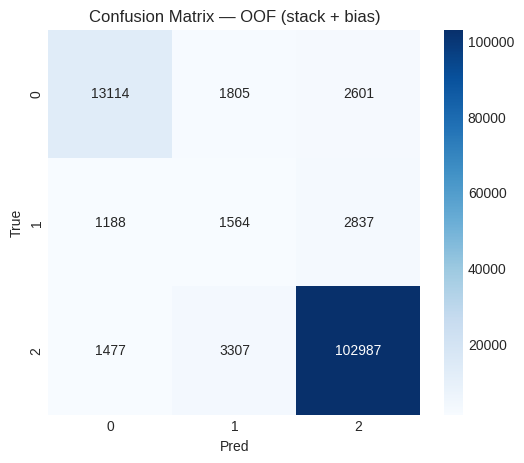

In [ ]:
# OOF diagnostics
z_oof = np.log(ensembled_oof_probs + 1e-12) + b_opt[None, :]
pred_oof = z_oof.argmax(1)
print("\nClassification Report (OOF, stacked+bias):")
print(classification_report(y, pred_oof, digits=3))
cm = confusion_matrix(y, pred_oof)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — OOF (stack + bias)")
plt.xlabel("Pred"); plt.ylabel("True"); plt.show()


📈 Visualizing Feature Importances...

--- XGBoost Feature Importance ---


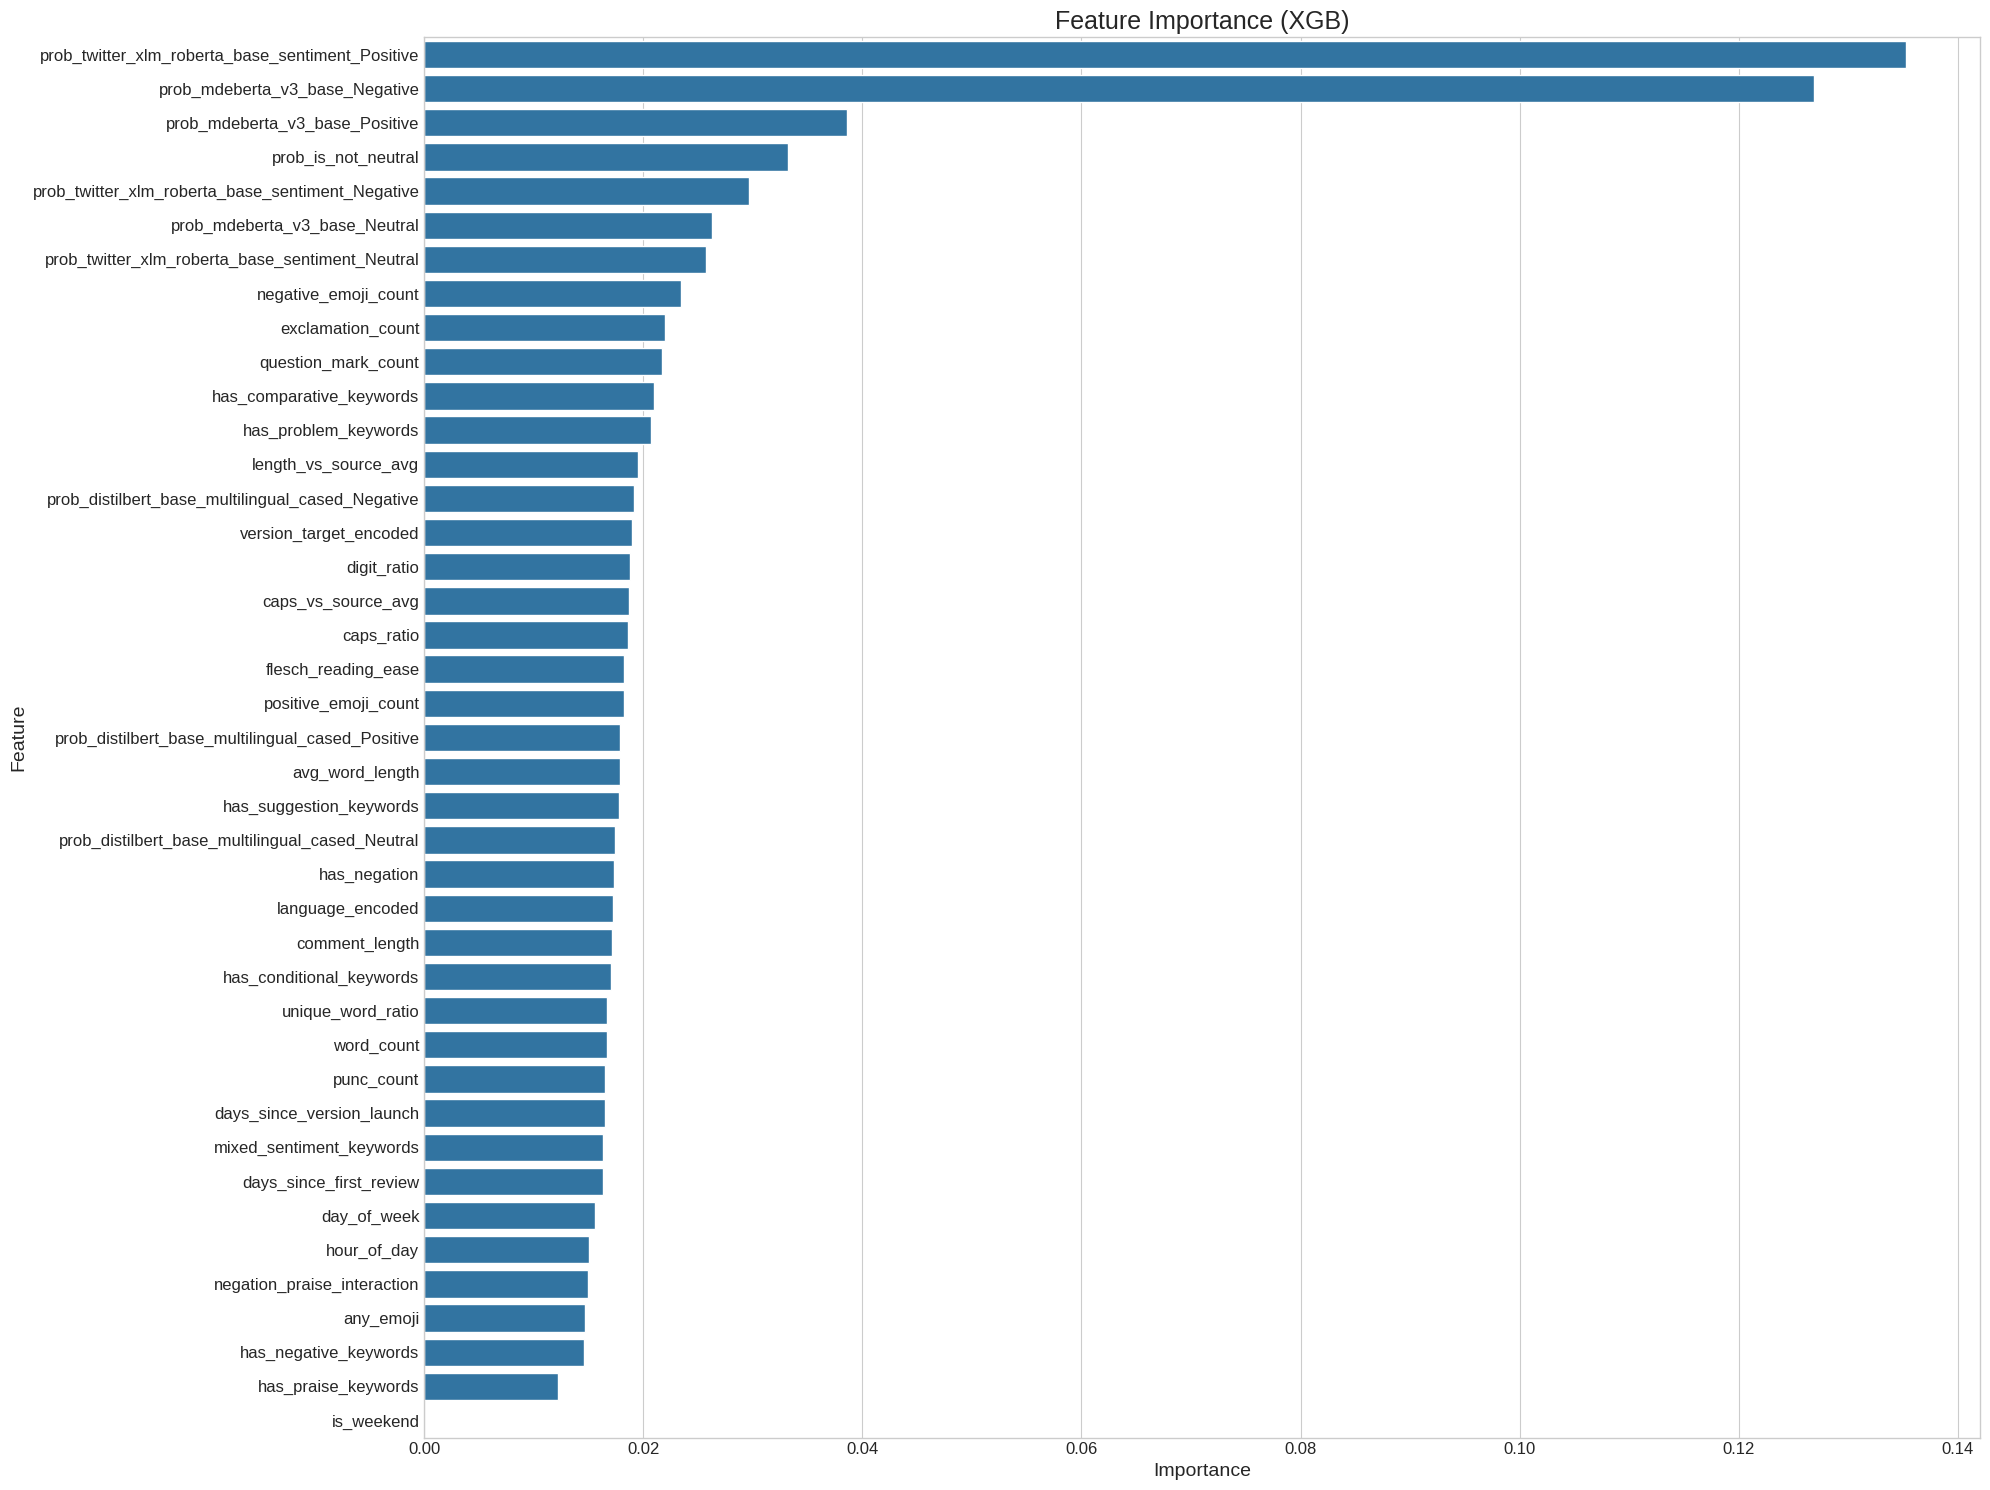


--- LightGBM Feature Importance ---


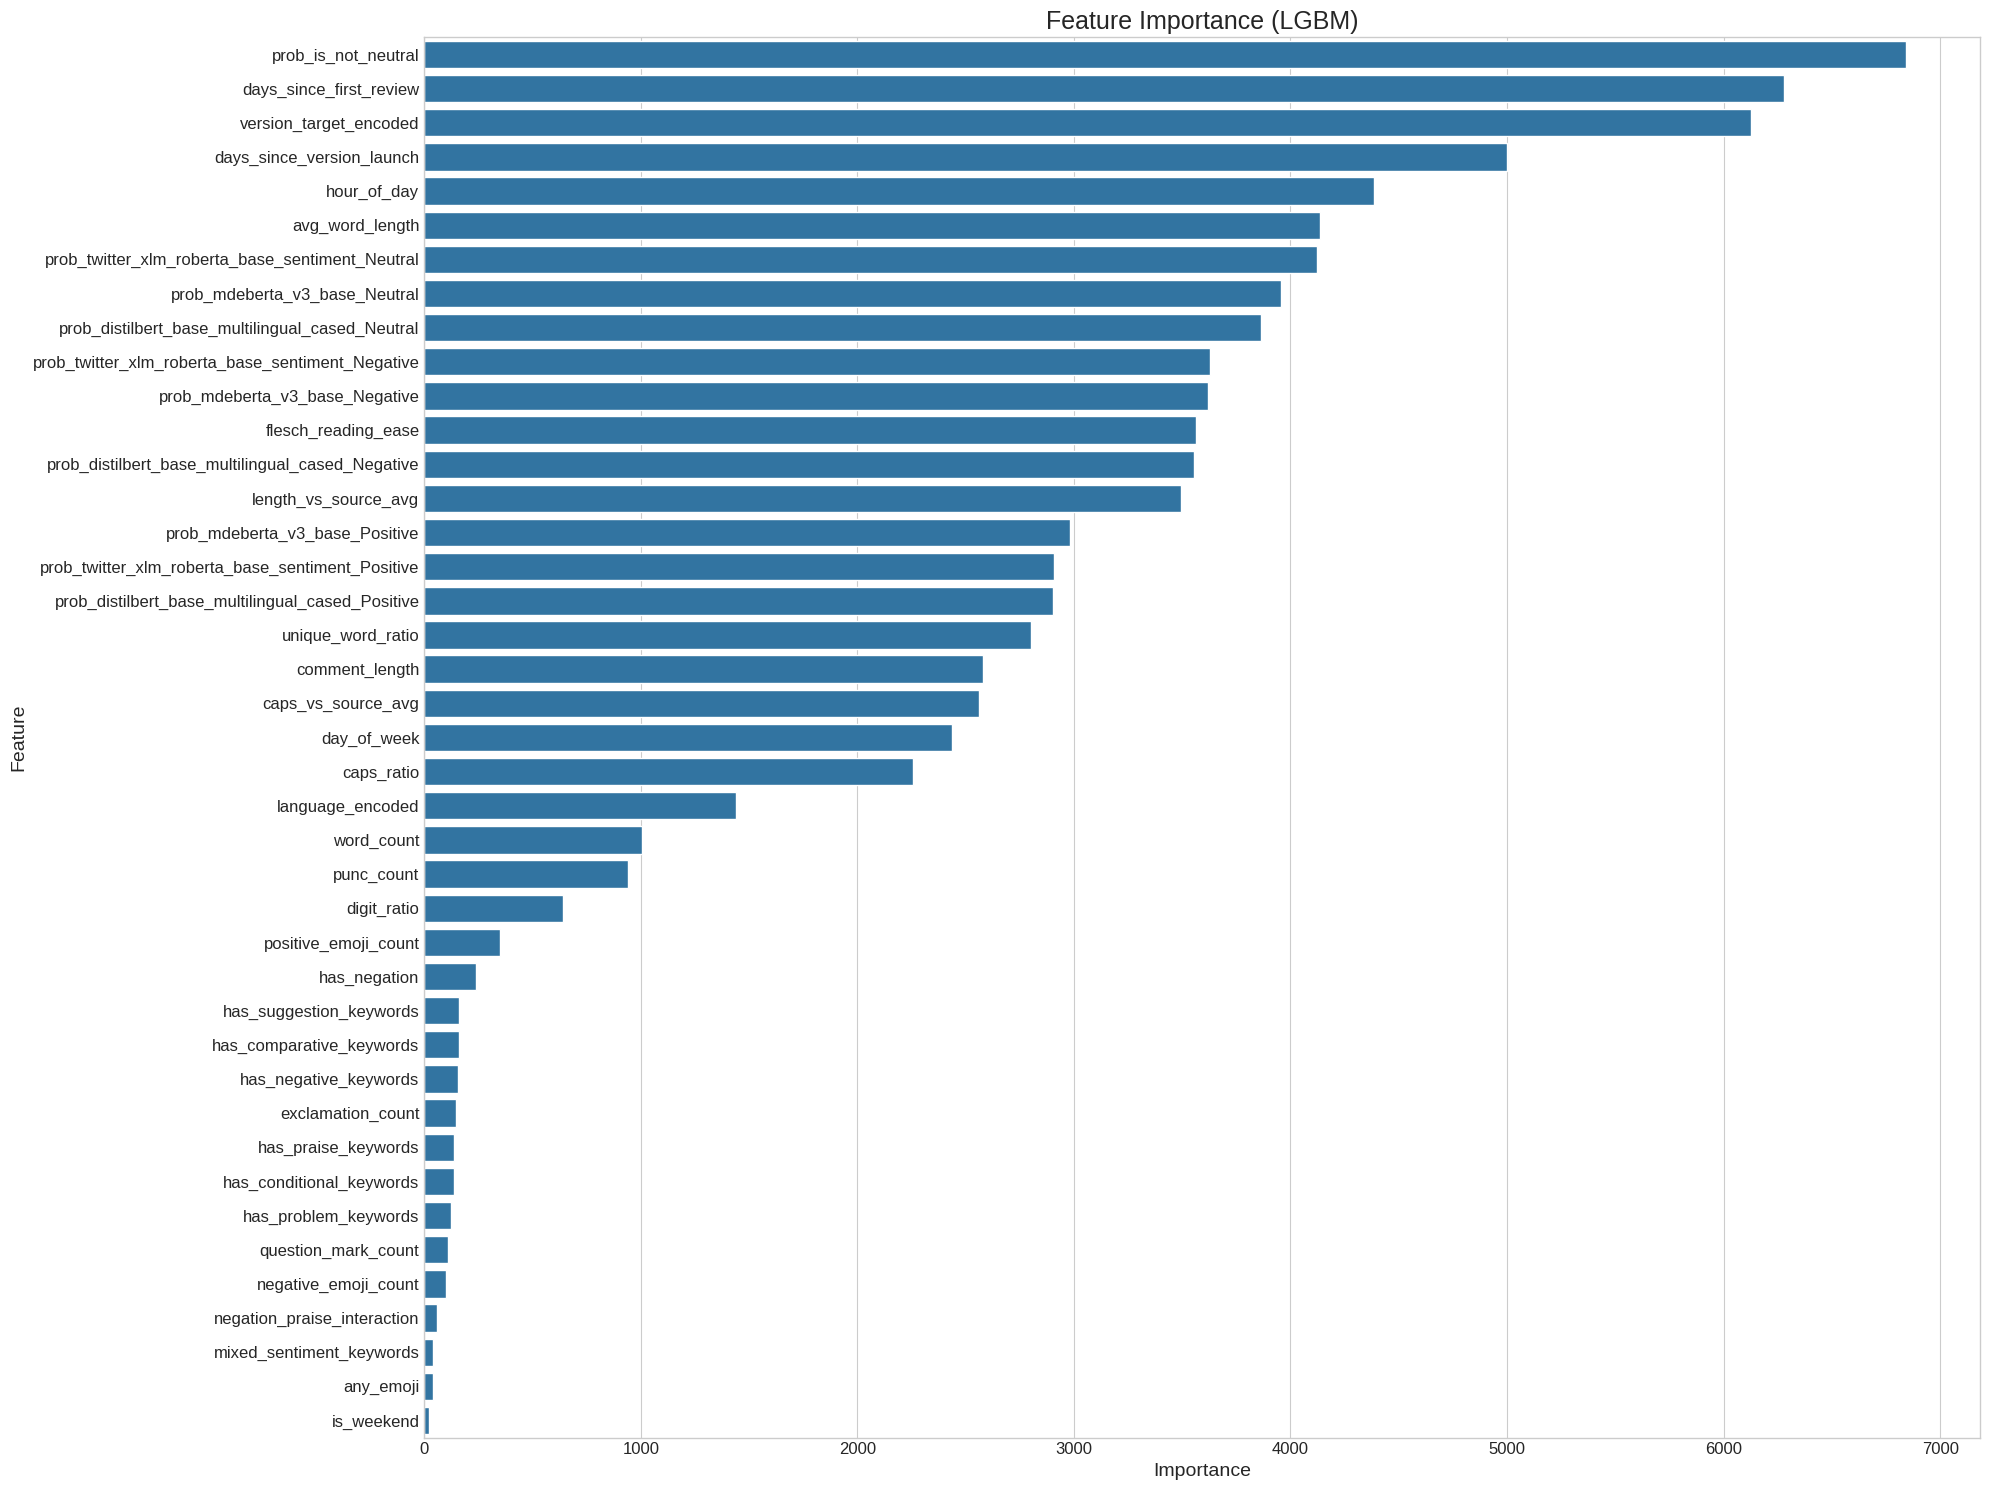


--- CatBoost Feature Importance ---


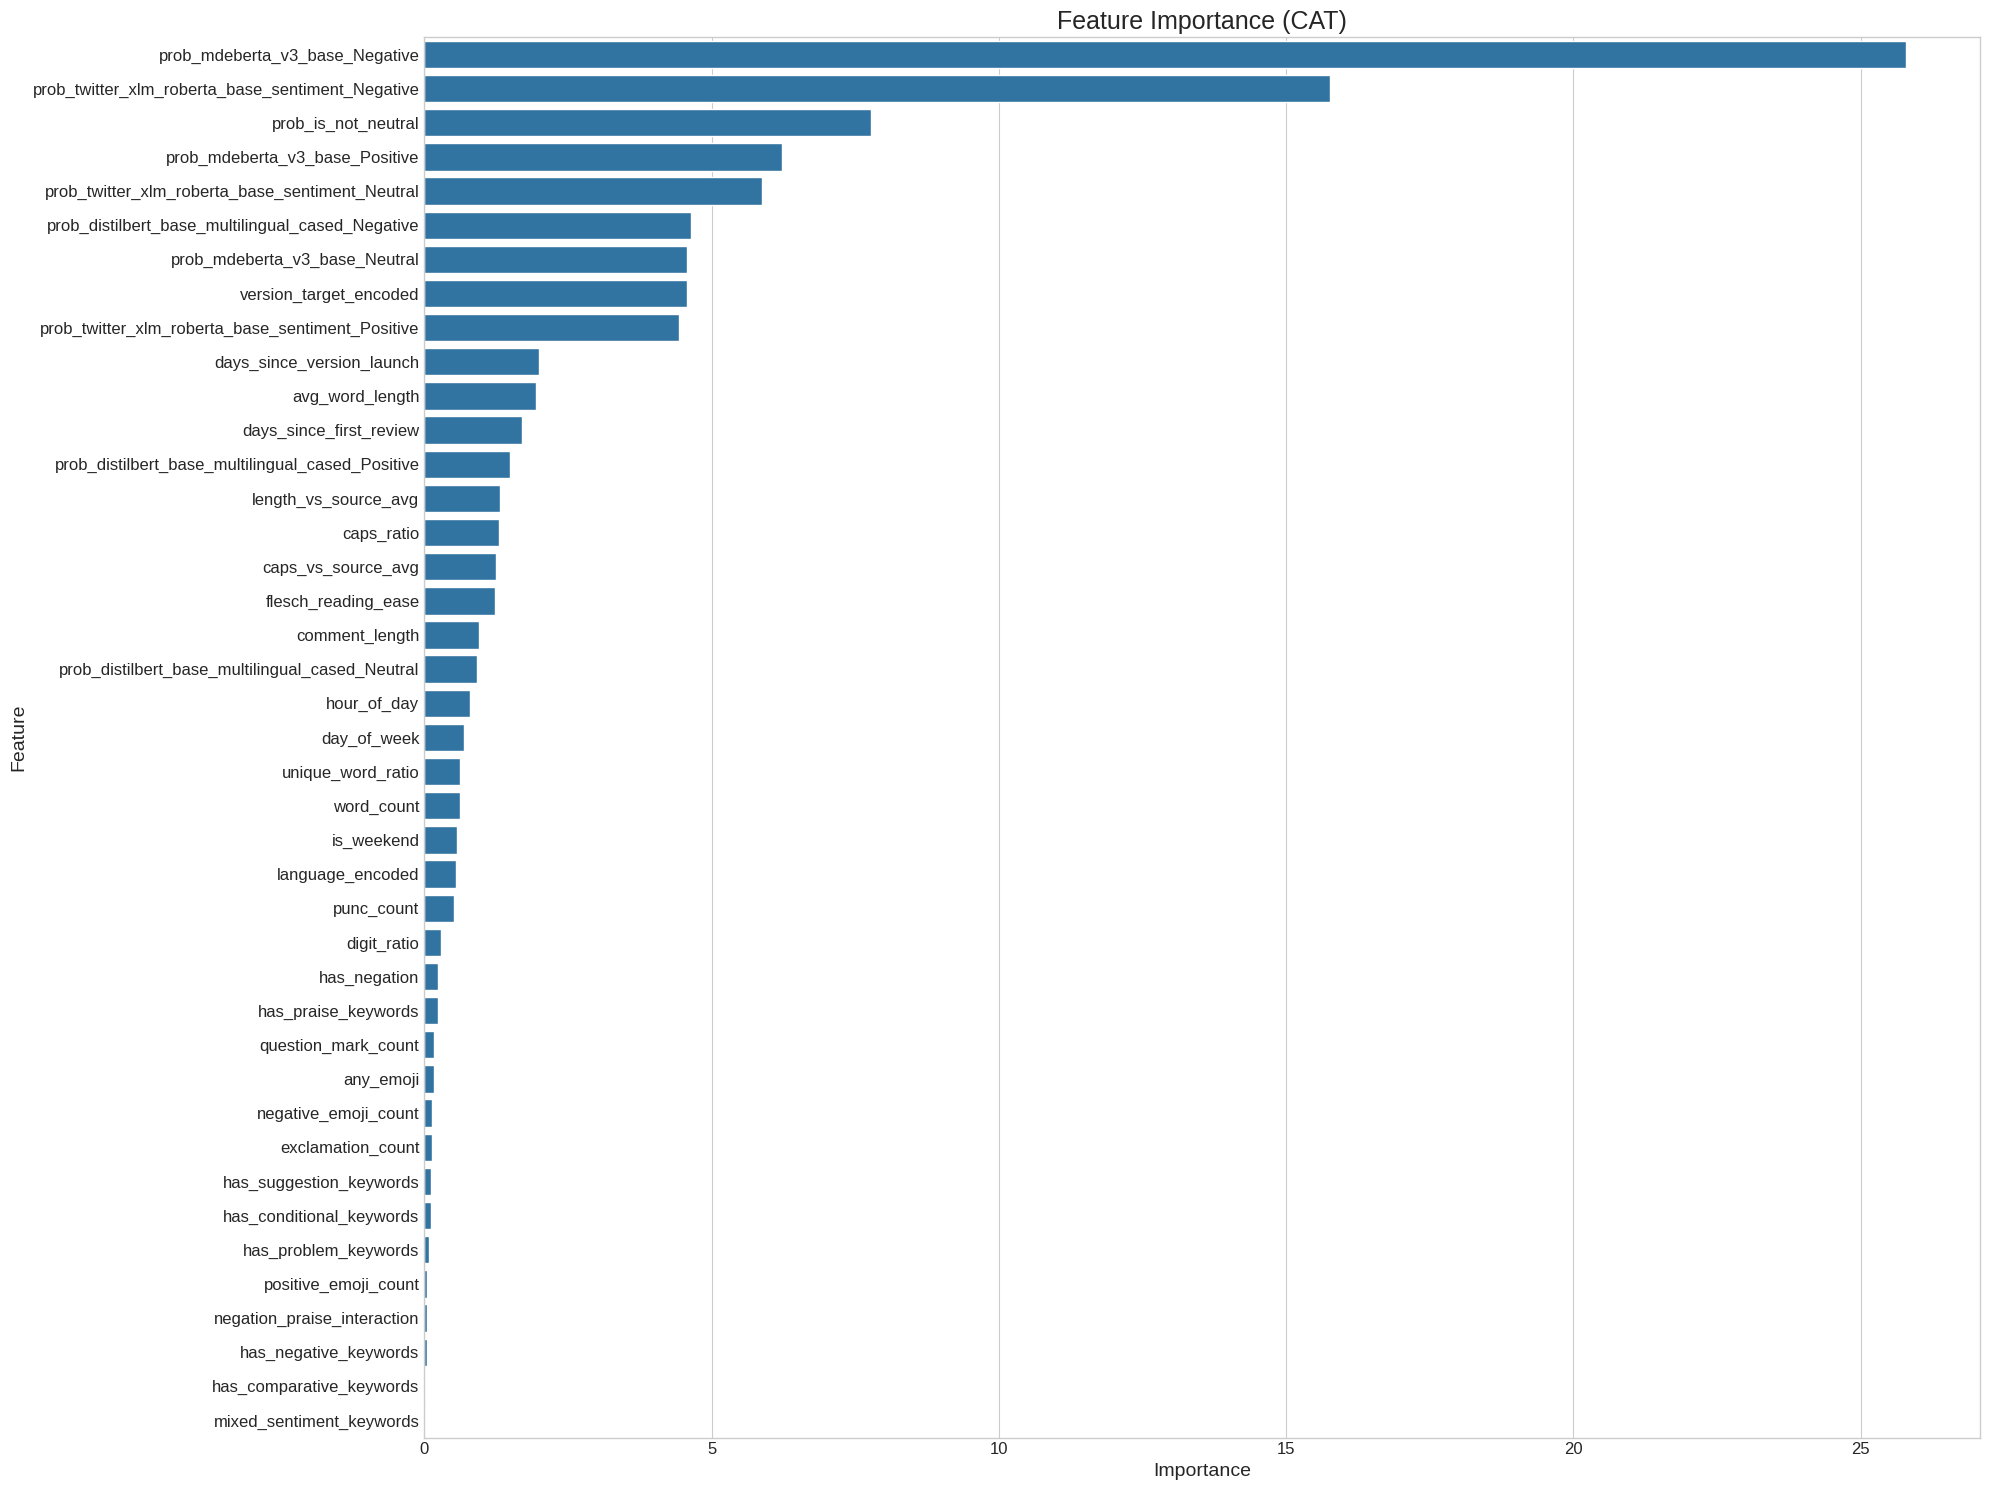


✅ Feature importance plotting complete.


In [ ]:
print("\n📈 Visualizing Feature Importances...")

def plot_feature_importance(model, feature_cols, model_name):
    """
    Plots feature importance for a given model.
    """
    if model_name == 'xgb':
        importance = model.feature_importances_
    elif model_name == 'lgbm':
        importance = model.feature_importances_
    elif model_name == 'cat':
        importance = model.get_feature_importance()
    else:
        print(f"Feature importance not supported for {model_name}")
        return

    feature_importance_df = pd.DataFrame({'feature': feature_cols, 'importance': importance})
    feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

    plt.figure(figsize=(20, 15)) # Increased figure height
    sns.barplot(x='importance', y='feature', data=feature_importance_df)
    plt.title(f'Feature Importance ({model_name.upper()})', fontsize=18) # Increased title font size
    plt.xlabel('Importance', fontsize=14) # Increased xlabel font size
    plt.ylabel('Feature', fontsize=14) # Increased ylabel font size
    plt.xticks(fontsize=12) # Increased xticks font size
    plt.yticks(fontsize=12) # Increased yticks font size
    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()

# Plot feature importances for each trained model
# Assuming the train_model function in the previous cell is modified to return models
print("\n--- XGBoost Feature Importance ---")
plot_feature_importance(xgb_model, feature_cols, 'xgb')

print("\n--- LightGBM Feature Importance ---")
plot_feature_importance(lgbm_model, feature_cols, 'lgbm')

print("\n--- CatBoost Feature Importance ---")
plot_feature_importance(cat_model, feature_cols, 'cat')

print("\n✅ Feature importance plotting complete.")